# Regression Comparison

In [1]:
import os
import time
import csv
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shutil
import numpy as np

from pyspark.sql import functions as sql_f
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import col, when, month, lag
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.storagelevel import StorageLevel
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit

## Auxiliary Functions

In [2]:
# --- Auxiliary Functions ---
BASE_OUTPUT_DIR = "saved_models"
MASTER_LOG_FILE = "model_comparison.csv"
BASE_DATA_PATH = "processed_data"

def get_paths(years):
    """
    Generates file paths for the specific years.
    """
    # Points to the folder year=YYYY inside processed_data
    # Spark will automatically find the .parquet files inside these folders
    return [f"{BASE_DATA_PATH}/year={y}" for y in years]
    
def save_training_history(model, output_dir, model_name):
    """
    Checks for training history. 
    """
    history_path = os.path.join(output_dir, "training_history.csv")
    
    # Check if the model has a summary and objective history (LinearReg)
    if hasattr(model, "summary") and hasattr(model.summary, "objectiveHistory"):
        history = model.summary.objectiveHistory
        df_hist = pd.DataFrame({
            "Iteration": range(1, len(history) + 1),
            "Objective_Loss": history
        })
        df_hist.to_csv(history_path, index=False)
        
        plt.figure(figsize=(8, 4))
        plt.plot(df_hist["Iteration"], df_hist["Objective_Loss"], marker='o')
        plt.title(f"Convergence Curve - {model_name}")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, "convergence_plot.png"))
        plt.close()
        print(f"   [v] Training history saved.")
    else:
        # Decision Trees, Random Forest and GBT fall here
        print(f"   [i] Note: {model_name} does not produce an iterative convergence plot.")

def evaluate_and_log(predictions, target_col, time_taken, output_dir, model_name):
    """
    Calculates metrics, saves to Master CSV and local JSON.
    """
    evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction")
    
    r2 = evaluator.setMetricName("r2").evaluate(predictions)
    rmse = evaluator.setMetricName("rmse").evaluate(predictions)
    mae = evaluator.setMetricName("mae").evaluate(predictions)
    
    snow_subset = predictions.filter(col(target_col) > 0)
    r2_snow = evaluator.setMetricName("r2").evaluate(snow_subset) if snow_subset.count() > 0 else 0.0

    metrics = {
        "Model": model_name,
        "Time_Sec": round(time_taken, 2),
        "R2_Global": round(r2, 4),
        "RMSE_Global": round(rmse, 4),
        "MAE_Global": round(mae, 4),
        "R2_Snow_Only": round(r2_snow, 4)
    }

    file_exists = os.path.isfile(MASTER_LOG_FILE)
    with open(MASTER_LOG_FILE, mode='a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=metrics.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(metrics)
    
    with open(os.path.join(output_dir, "metrics.json"), 'w') as f:
        json.dump(metrics, f, indent=4)

    print(f"\n--- METRICS ({model_name}) ---")
    print(f"R2: {r2:.4f} | RMSE: {rmse:.4f} | R2 Snow Only: {r2_snow:.4f}")
    return metrics

def plot_predictions(predictions, target_col, output_dir, model_name):
    """
    Generates and saves Scatter and Residual plots.
    """
    print("   Generating plots...")
    # LIMITATION: Taking a sample to avoid crashing plotting libraries with 5M+ points
    pdf = predictions.select(target_col, "prediction").sample(False, 0.05, seed=42).toPandas()
    
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=pdf[target_col], y=pdf["prediction"], alpha=0.3)
    plt.plot([pdf[target_col].min(), pdf[target_col].max()], 
             [pdf[target_col].min(), pdf[target_col].max()], 'r--', lw=2)
    plt.xlabel('Reality')
    plt.ylabel('Prediction')
    plt.title(f'Prediction vs Reality - {model_name}')

    plt.subplot(1, 2, 2)
    residuals = pdf[target_col] - pdf["prediction"]
    sns.histplot(residuals, bins=50, kde=True)
    plt.xlabel('Error (Real - Predicted)')
    plt.title('Residuals Distribution')
    
    plt.savefig(os.path.join(output_dir, "prediction_plots.png"))
    plt.close()
    print(f"   [v] Plots saved in: {output_dir}")

## Linear Regression

--- STARTING: LinearRegression_Baseline ---
Output Directory: saved_models/LinearRegression_Baseline
1. Loading Data (Full Dataset)...


   Features (20): ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'MAX', 'MIN', 'PRCP', 'is_Fog', 'is_Rain', 'is_Snow', 'is_Hail', 'is_Thunder', 'is_Tornado', 'Solid_PRCP']


   Training Rows: 51,018,114
2. Training LinearRegression_Baseline...


   Training completed in 41.82 seconds.
3. Processing Results...
Calculating feature importance...


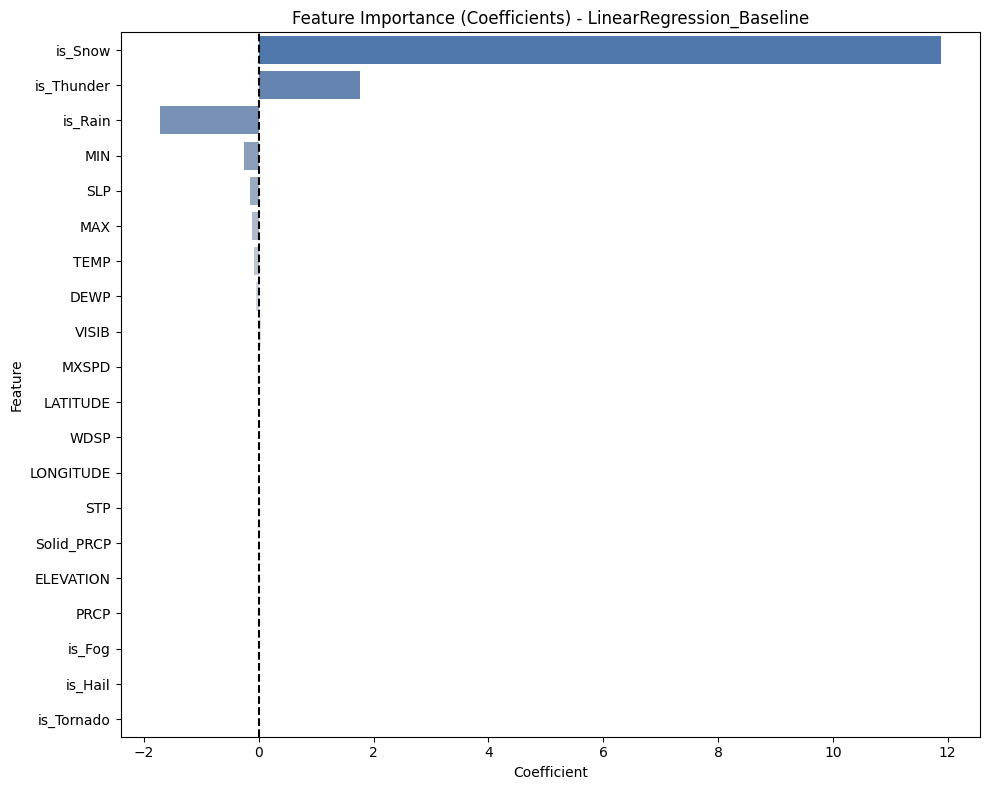


Top 10 Features by Coefficient:
   Feature  Coefficient
   is_Snow    11.884469
is_Thunder     1.767646
   is_Rain    -1.728602
       MIN    -0.263150
       SLP    -0.151340
       MAX    -0.111892
      TEMP    -0.089815
      DEWP    -0.052418
     VISIB     0.030932
     MXSPD    -0.025844
  LATITUDE    -0.005575
      WDSP    -0.004751
 LONGITUDE     0.002852
       STP    -0.000890
Solid_PRCP     0.000767
 ELEVATION     0.000459
      PRCP     0.000000
    is_Fog     0.000000
   is_Hail     0.000000
is_Tornado     0.000000
4. Saving model info...
   [v] Spark Model saved to: saved_models/LinearRegression_Baseline/spark_model
   [v] Training history (Loss) saved to: saved_models/LinearRegression_Baseline/training_history.csv
   Generating predictions on Validation Set...



--- METRICS (LinearRegression_Baseline) ---
R2: 0.3613 | RMSE: 9.5340 | R2 Snow Only: 0.0218
   Generating plots...


   [v] Plots saved in: saved_models/LinearRegression_Baseline

--- PROCESS FINISHED SUCCESSFULLY ---


In [7]:
MODEL_NAME = "LinearRegression_Baseline"

print(f"--- STARTING: {MODEL_NAME} ---")

# Calculate 70-80% of your total physical RAM. 
# Example: If you have 16GB RAM, use 12g for the driver.
TOTAL_RAM = "12g" 

spark = SparkSession.builder \
    .appName(MODEL_NAME) \
    .master("local[*]") \
    .config("spark.driver.memory", TOTAL_RAM) \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.2") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()
    

spark.sparkContext.setLogLevel("ERROR")

model_output_dir = os.path.join(BASE_OUTPUT_DIR, MODEL_NAME)
if os.path.exists(model_output_dir):
    shutil.rmtree(model_output_dir)
os.makedirs(model_output_dir)

print(f"Output Directory: {model_output_dir}")

train_years = range(2010, 2021) 
val_years   = range(2021, 2023) 

print("1. Loading Data (Full Dataset)...")
try:
    train_df = spark.read.parquet(*get_paths(train_years))
    val_df   = spark.read.parquet(*get_paths(val_years))
except Exception as e:
    print(f"Error loading data: {e}")
    spark.stop()
    raise e

target_col = "SNDP"
ignore_cols = [target_col, "DATE", "STATION", "NAME", "features", "prediction",
              'SNDP_lag1', 'SNDP_lag2', 'TEMP_lag1', 'SNDP_diff', 'weight', 'log_SNDP',
              'month_sin', 'month_cos']
valid_types = ['int', 'bigint', 'float', 'double', 'tinyint', 'smallint']

dtypes = train_df.dtypes
feature_cols = [c for c, t in dtypes if t in valid_types and c not in ignore_cols]
print(f"   Features ({len(feature_cols)}): {feature_cols}")

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features").setHandleInvalid("skip")

train_vec = assembler.transform(train_df)
val_vec   = assembler.transform(val_df)

train_vec.persist(StorageLevel.MEMORY_AND_DISK)
print(f"   Training Rows: {train_vec.count():,}")

print(f"2. Training {MODEL_NAME}...")

lr = LinearRegression(
    featuresCol="features", 
    labelCol=target_col,
    maxIter=50, 
    regParam=0.1, 
    elasticNetParam=0.5
)

start_time = time.time()
model = lr.fit(train_vec)
end_time = time.time()
duration = end_time - start_time

print(f"   Training completed in {duration:.2f} seconds.")

print("3. Processing Results...")

print("Calculating feature importance...")
# 1. Extract coefficients and names of columns
coefficients = model.coefficients.toArray()
attributes = feature_cols

# 2. Create a Pandas DataFrame for easy visualization
importance_df = pd.DataFrame({
    'Feature': attributes,
    'Coefficient': coefficients,
    'Absolute_Coefficient': np.abs(coefficients)
})

# 3. Order by absolute value
importance_df = importance_df.sort_values(by='Absolute_Coefficient', ascending=False)

# 4. Visualize
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=importance_df, palette='vlag', hue='Feature', legend=False)
plt.title(f'Feature Importance (Coefficients) - {MODEL_NAME}')
plt.axvline(x=0, color='black', linestyle='--') # Línea en 0 para ver positivos vs negativos
plt.tight_layout()

# Save graph
plt.savefig(os.path.join(model_output_dir, "feature_importance.png"))
plt.show()

# Show Top 10 
print("\nTop 10 Features by Coefficient:")
print(importance_df[['Feature', 'Coefficient']].to_string(index=False))

print("4. Saving model info...")
model_save_path = os.path.join(model_output_dir, "spark_model")
model.write().overwrite().save(model_save_path)
print(f"   [v] Spark Model saved to: {model_save_path}")

save_training_history(model, model_output_dir, MODEL_NAME)

print("   Generating predictions on Validation Set...")
val_preds = model.transform(val_vec)
metrics = evaluate_and_log(val_preds, target_col, duration, model_output_dir, MODEL_NAME)

plot_predictions(val_preds, target_col, model_output_dir, MODEL_NAME)

print("\n--- PROCESS FINISHED SUCCESSFULLY ---")
spark.stop()

## Decision Tree

--- STARTING: DecisionTree_Baseline ---
Output Directory: saved_models/DecisionTree_Baseline
1. Loading Data (Full Dataset)...
   Features (20): ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'MAX', 'MIN', 'PRCP', 'is_Fog', 'is_Rain', 'is_Snow', 'is_Hail', 'is_Thunder', 'is_Tornado', 'Solid_PRCP']


   Training Rows: 51,018,114
2. Training DecisionTree_Baseline...


/tmp/ipykernel_2997/1966069961.py:95: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_r')


   Training completed in 127.17 seconds.
3. Processing Results...
Calculating feature importance...

Top 10 Features by Importance:
   Feature  Importance
      TEMP    0.794087
  LATITUDE    0.053289
 LONGITUDE    0.045653
 ELEVATION    0.045158
       MIN    0.028914
       STP    0.016687
       MAX    0.010246
      DEWP    0.004269
       SLP    0.001697
     VISIB    0.000000
     MXSPD    0.000000
      WDSP    0.000000
      PRCP    0.000000
    is_Fog    0.000000
   is_Rain    0.000000
   is_Snow    0.000000
   is_Hail    0.000000
is_Thunder    0.000000
is_Tornado    0.000000
Solid_PRCP    0.000000
4. Saving model info...
   [v] Spark Model saved to: saved_models/DecisionTree_Baseline/spark_model
   [i] Note: DecisionTree_Baseline does not produce an iterative convergence plot.
   Generating predictions on Validation Set...



--- METRICS (DecisionTree_Baseline) ---
R2: 0.4996 | RMSE: 8.4388 | R2 Snow Only: 0.1591
   Generating plots...


   [v] Plots saved in: saved_models/DecisionTree_Baseline

--- PROCESS FINISHED SUCCESSFULLY ---


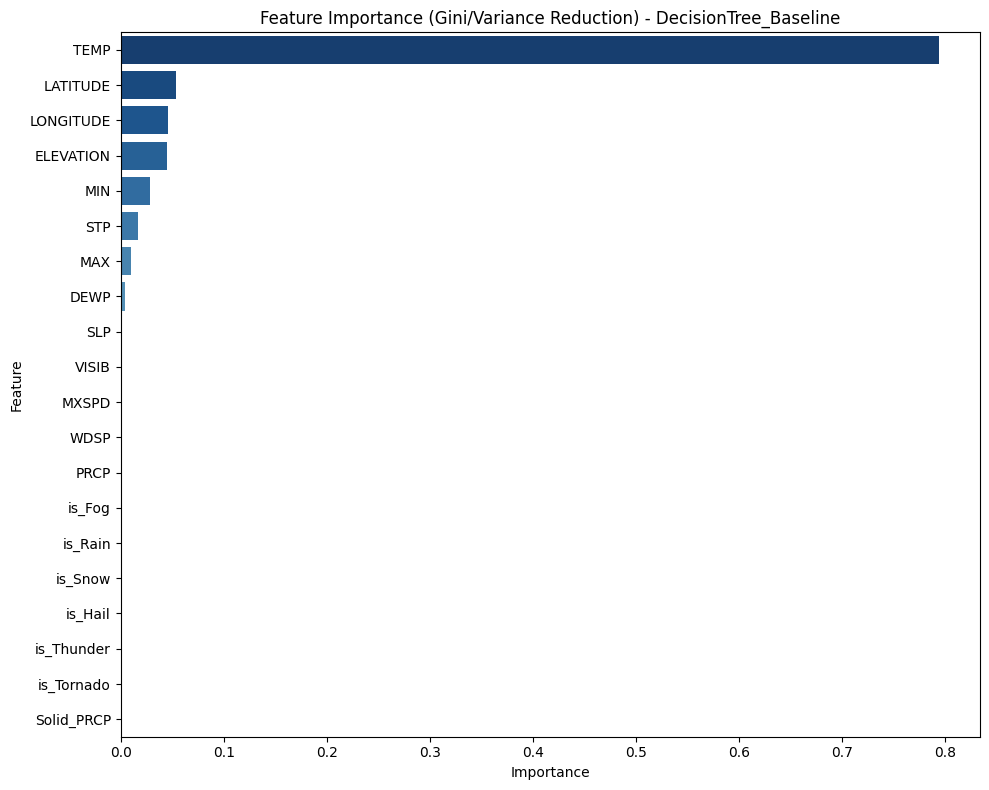

In [11]:
MODEL_NAME = "DecisionTree_Baseline"

print(f"--- STARTING: {MODEL_NAME} ---")

# Memory Configuration
TOTAL_RAM = "12g" 

spark = SparkSession.builder \
    .appName(MODEL_NAME) \
    .master("local[*]") \
    .config("spark.driver.memory", TOTAL_RAM) \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.2") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

model_output_dir = os.path.join(BASE_OUTPUT_DIR, MODEL_NAME)
if os.path.exists(model_output_dir):
    shutil.rmtree(model_output_dir)
os.makedirs(model_output_dir)

print(f"Output Directory: {model_output_dir}")

train_years = range(2010, 2021) 
val_years   = range(2021, 2023) 

print("1. Loading Data (Full Dataset)...")
try:
    train_df = spark.read.parquet(*get_paths(train_years))
    val_df   = spark.read.parquet(*get_paths(val_years))
except Exception as e:
    print(f"Error loading data: {e}")
    spark.stop()
    raise e

target_col = "SNDP"
# ignore_cols = [target_col, "DATE", "STATION", "NAME", "features", "prediction"]
ignore_cols = [target_col, "DATE", "STATION", "NAME", "features", "prediction",
              'SNDP_lag1', 'SNDP_lag2', 'TEMP_lag1', 'SNDP_diff', 'weight', 'log_SNDP',
              'month_sin', 'month_cos']
valid_types = ['int', 'bigint', 'float', 'double', 'tinyint', 'smallint']

dtypes = train_df.dtypes
feature_cols = [c for c, t in dtypes if t in valid_types and c not in ignore_cols]
print(f"   Features ({len(feature_cols)}): {feature_cols}")

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features").setHandleInvalid("skip")

train_vec = assembler.transform(train_df)
val_vec   = assembler.transform(val_df)

train_vec.persist(StorageLevel.MEMORY_AND_DISK)
print(f"   Training Rows: {train_vec.count():,}")

print(f"2. Training {MODEL_NAME}...")

dt = DecisionTreeRegressor(
    featuresCol="features", 
    labelCol=target_col,
    maxDepth=5,       # Baseline depth, can be increased (e.g., 10) later
    maxBins=32,       # Number of bins for continuous features
    seed=42
)

start_time = time.time()
model = dt.fit(train_vec)
end_time = time.time()
duration = end_time - start_time

print(f"   Training completed in {duration:.2f} seconds.")

print("3. Processing Results...")

print("Calculating feature importance...")
# Decision Trees use 'featureImportances', not 'coefficients'
# featureImportances returns a sparse vector, we convert to dense array
importances = model.featureImportances.toArray()
attributes = feature_cols

# Create a Pandas DataFrame
importance_df = pd.DataFrame({
    'Feature': attributes,
    'Importance': importances
})

# Order by Importance (Desc)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualize
plt.figure(figsize=(10, 8))
# Color palette (blues) better for importances (always positive)
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_r')
plt.title(f'Feature Importance (Gini/Variance Reduction) - {MODEL_NAME}')
plt.tight_layout()

# Save graph
plt.savefig(os.path.join(model_output_dir, "feature_importance.png"))
# plt.show() # Commented out for server safety

# Show Top 10 
print("\nTop 10 Features by Importance:")
print(importance_df[['Feature', 'Importance']].to_string(index=False))

print("4. Saving model info...")
model_save_path = os.path.join(model_output_dir, "spark_model")
model.write().overwrite().save(model_save_path)
print(f"   [v] Spark Model saved to: {model_save_path}")

# This will print a message saying DT doesn't support history plots
save_training_history(model, model_output_dir, MODEL_NAME)

print("   Generating predictions on Validation Set...")
val_preds = model.transform(val_vec)
metrics = evaluate_and_log(val_preds, target_col, duration, model_output_dir, MODEL_NAME)

plot_predictions(val_preds, target_col, model_output_dir, MODEL_NAME)

print("\n--- PROCESS FINISHED SUCCESSFULLY ---")
spark.stop()

## Random Forest

--- STARTING: RandomForest_Baseline ---
Output Directory: saved_models/RandomForest_Baseline
1. Loading Data (Full Dataset)...
   Features (20): ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'MAX', 'MIN', 'PRCP', 'is_Fog', 'is_Rain', 'is_Snow', 'is_Hail', 'is_Thunder', 'is_Tornado', 'Solid_PRCP']


   Training Rows: 51,018,114
2. Training RandomForest_Baseline...


   Training completed in 441.75 seconds.
3. Processing Results...
Calculating feature importance...


/tmp/ipykernel_2997/2762657965.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Greens_r') # Using Greens for Forest



Top 10 Features by Importance:
   Feature   Importance
       MAX 3.063367e-01
       MIN 2.174018e-01
      TEMP 1.777353e-01
      DEWP 1.006762e-01
Solid_PRCP 6.375918e-02
  LATITUDE 4.391186e-02
 ELEVATION 3.291195e-02
   is_Snow 1.978028e-02
 LONGITUDE 1.455750e-02
       SLP 9.976230e-03
       STP 5.861070e-03
     VISIB 3.047091e-03
     MXSPD 1.869317e-03
      WDSP 1.529150e-03
    is_Fog 4.963389e-04
      PRCP 9.861595e-05
   is_Rain 5.136198e-05
is_Thunder 1.778062e-09
   is_Hail 0.000000e+00
is_Tornado 0.000000e+00
4. Saving model info...
   [v] Spark Model saved to: saved_models/RandomForest_Baseline/spark_model
   [i] Note: RandomForest_Baseline does not produce an iterative convergence plot.
   Generating predictions on Validation Set...



--- METRICS (RandomForest_Baseline) ---
R2: 0.5048 | RMSE: 8.3946 | R2 Snow Only: 0.1659
   Generating plots...


   [v] Plots saved in: saved_models/RandomForest_Baseline

--- PROCESS FINISHED SUCCESSFULLY ---


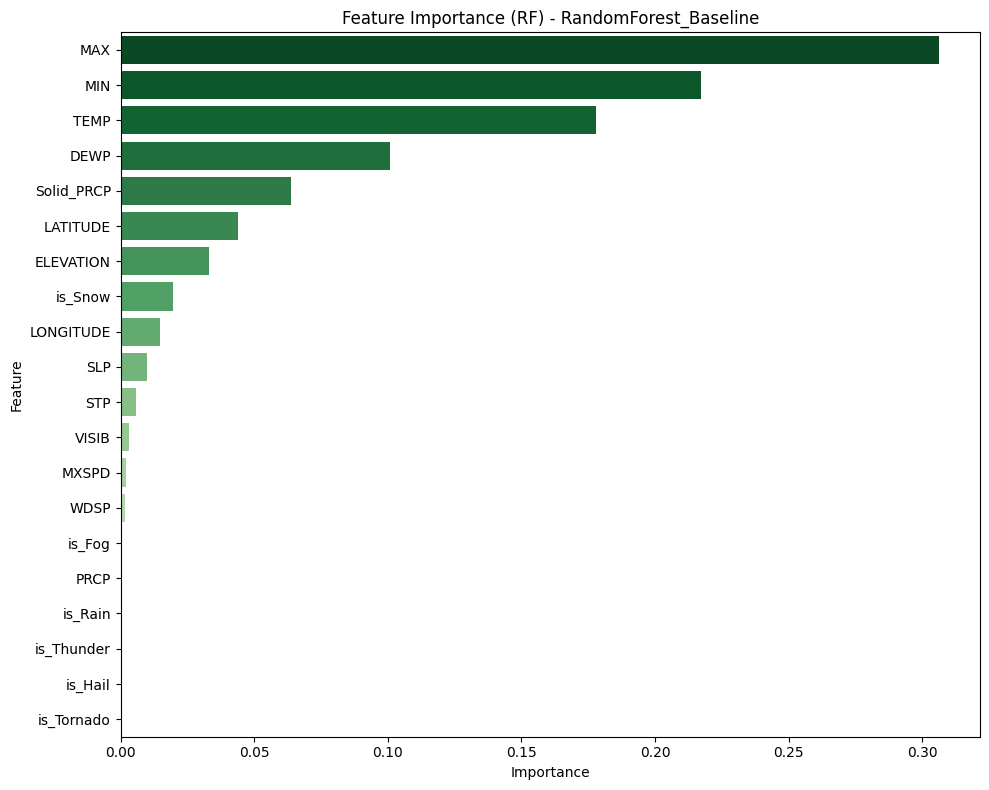

In [12]:
MODEL_NAME = "RandomForest_Baseline"

print(f"--- STARTING: {MODEL_NAME} ---")

# Memory Configuration
TOTAL_RAM = "12g" 

spark = SparkSession.builder \
    .appName(MODEL_NAME) \
    .master("local[*]") \
    .config("spark.driver.memory", TOTAL_RAM) \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.2") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

model_output_dir = os.path.join(BASE_OUTPUT_DIR, MODEL_NAME)
if os.path.exists(model_output_dir):
    shutil.rmtree(model_output_dir)
os.makedirs(model_output_dir)

print(f"Output Directory: {model_output_dir}")

train_years = range(2010, 2021) 
val_years   = range(2021, 2023) 

print("1. Loading Data (Full Dataset)...")
try:
    train_df = spark.read.parquet(*get_paths(train_years))
    val_df   = spark.read.parquet(*get_paths(val_years))
except Exception as e:
    print(f"Error loading data: {e}")
    spark.stop()
    raise e

target_col = "SNDP"
ignore_cols = [target_col, "DATE", "STATION", "NAME", "features", "prediction",
               'SNDP_lag1', 'SNDP_lag2', 'TEMP_lag1', 'SNDP_diff', 'weight', 'log_SNDP',
               'month_sin', 'month_cos']
valid_types = ['int', 'bigint', 'float', 'double', 'tinyint', 'smallint']

dtypes = train_df.dtypes
feature_cols = [c for c, t in dtypes if t in valid_types and c not in ignore_cols]
print(f"   Features ({len(feature_cols)}): {feature_cols}")

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features").setHandleInvalid("skip")

train_vec = assembler.transform(train_df)
val_vec   = assembler.transform(val_df)

train_vec.persist(StorageLevel.MEMORY_AND_DISK)
print(f"   Training Rows: {train_vec.count():,}")

print(f"2. Training {MODEL_NAME}...")

# CHANGED: Using RandomForestRegressor
rf = RandomForestRegressor(
    featuresCol="features", 
    labelCol=target_col,
    numTrees=20,      # Number of trees (can be increased to 50 or 100 later)
    maxDepth=5,       # Baseline depth
    maxBins=32,       # Number of bins for continuous features
    seed=42
)

start_time = time.time()
model = rf.fit(train_vec)
end_time = time.time()
duration = end_time - start_time

print(f"   Training completed in {duration:.2f} seconds.")

print("3. Processing Results...")

print("Calculating feature importance...")
# Random Forests also use 'featureImportances', same as Decision Trees
importances = model.featureImportances.toArray()
attributes = feature_cols

# Create a Pandas DataFrame
importance_df = pd.DataFrame({
    'Feature': attributes,
    'Importance': importances
})

# Order by Importance (Desc)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualize
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Greens_r') # Using Greens for Forest
plt.title(f'Feature Importance (RF) - {MODEL_NAME}')
plt.tight_layout()

# Save graph
plt.savefig(os.path.join(model_output_dir, "feature_importance.png"))
# plt.show() 

# Show Top 10 
print("\nTop 10 Features by Importance:")
print(importance_df[['Feature', 'Importance']].to_string(index=False))

print("4. Saving model info...")
model_save_path = os.path.join(model_output_dir, "spark_model")
model.write().overwrite().save(model_save_path)
print(f"   [v] Spark Model saved to: {model_save_path}")

save_training_history(model, model_output_dir, MODEL_NAME)

print("   Generating predictions on Validation Set...")
val_preds = model.transform(val_vec)
metrics = evaluate_and_log(val_preds, target_col, duration, model_output_dir, MODEL_NAME)

plot_predictions(val_preds, target_col, model_output_dir, MODEL_NAME)

print("\n--- PROCESS FINISHED SUCCESSFULLY ---")
spark.stop()

## GBT Regression

--- STARTING: GBT_Baseline ---
Output Directory: saved_models/GBT_Baseline
1. Loading Data (Full Dataset)...
   Features (20): ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'MAX', 'MIN', 'PRCP', 'is_Fog', 'is_Rain', 'is_Snow', 'is_Hail', 'is_Thunder', 'is_Tornado', 'Solid_PRCP']


   Training Rows: 51,018,114
2. Training GBT_Baseline...


   Training completed in 1576.90 seconds.
3. Processing Results...
Calculating feature importance...


/tmp/ipykernel_2997/1117895198.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Oranges_r')



Top 10 Features by Importance:
   Feature  Importance
      TEMP    0.387534
 LONGITUDE    0.184072
  LATITUDE    0.137928
 ELEVATION    0.122241
       MIN    0.043967
       MAX    0.030372
      DEWP    0.028428
       SLP    0.018080
       STP    0.015182
Solid_PRCP    0.011577
     VISIB    0.005933
      PRCP    0.004750
     MXSPD    0.004065
   is_Rain    0.003935
   is_Snow    0.001698
      WDSP    0.000237
    is_Fog    0.000000
   is_Hail    0.000000
is_Thunder    0.000000
is_Tornado    0.000000
4. Saving model info...
   [v] Spark Model saved to: saved_models/GBT_Baseline/spark_model
   [i] Note: GBT_Baseline does not produce an iterative convergence plot.
   Generating predictions on Validation Set...



--- METRICS (GBT_Baseline) ---
R2: 0.5451 | RMSE: 8.0461 | R2 Snow Only: 0.2347
   Generating plots...


   [v] Plots saved in: saved_models/GBT_Baseline

--- PROCESS FINISHED SUCCESSFULLY ---


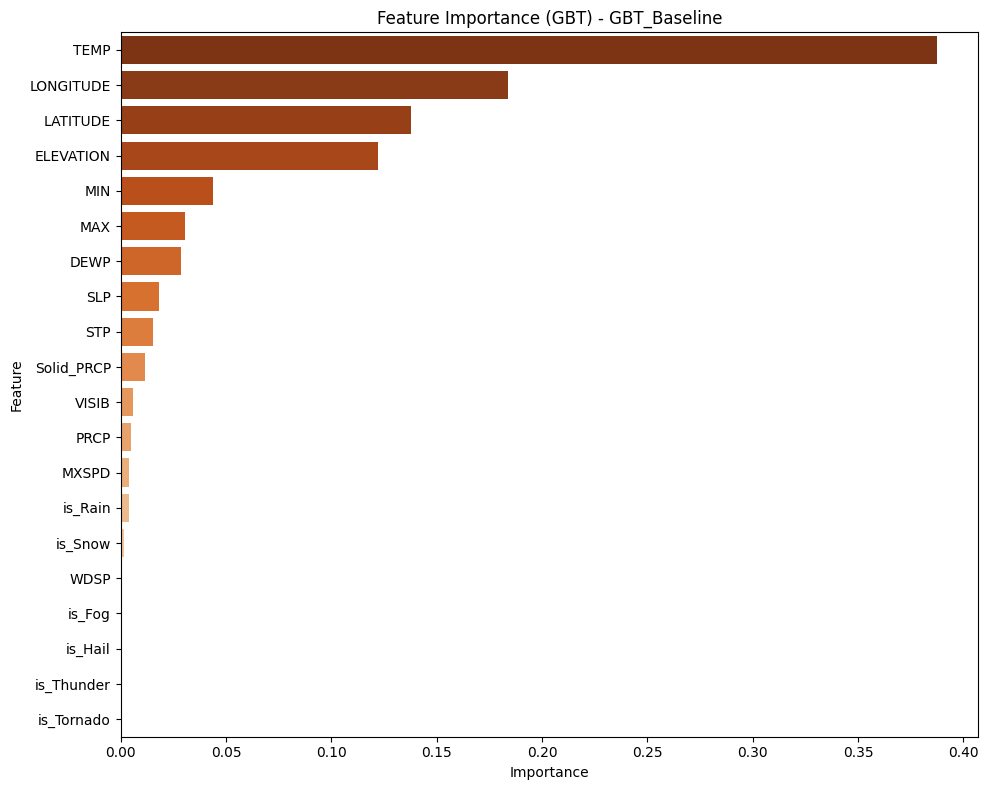

In [14]:
MODEL_NAME = "GBT_Baseline"

print(f"--- STARTING: {MODEL_NAME} ---")

# Memory Configuration
TOTAL_RAM = "12g" 

spark = SparkSession.builder \
    .appName(MODEL_NAME) \
    .master("local[*]") \
    .config("spark.driver.memory", TOTAL_RAM) \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.2") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

model_output_dir = os.path.join(BASE_OUTPUT_DIR, MODEL_NAME)
if os.path.exists(model_output_dir):
    shutil.rmtree(model_output_dir)
os.makedirs(model_output_dir)

print(f"Output Directory: {model_output_dir}")

train_years = range(2010, 2021) 
val_years   = range(2021, 2023) 

print("1. Loading Data (Full Dataset)...")
try:
    train_df = spark.read.parquet(*get_paths(train_years))
    val_df   = spark.read.parquet(*get_paths(val_years))
except Exception as e:
    print(f"Error loading data: {e}")
    spark.stop()
    raise e

target_col = "SNDP"
ignore_cols = [target_col, "DATE", "STATION", "NAME", "features", "prediction",
               'SNDP_lag1', 'SNDP_lag2', 'TEMP_lag1', 'SNDP_diff', 'weight', 'log_SNDP',
               'month_sin', 'month_cos']
valid_types = ['int', 'bigint', 'float', 'double', 'tinyint', 'smallint']

dtypes = train_df.dtypes
feature_cols = [c for c, t in dtypes if t in valid_types and c not in ignore_cols]
print(f"   Features ({len(feature_cols)}): {feature_cols}")

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features").setHandleInvalid("skip")

train_vec = assembler.transform(train_df)
val_vec   = assembler.transform(val_df)

train_vec.persist(StorageLevel.MEMORY_AND_DISK)
print(f"   Training Rows: {train_vec.count():,}")

print(f"2. Training {MODEL_NAME}...")

# CHANGED: Using GBTRegressor
# GBTs are sequential and take longer than RF to train. Keeping maxIter low (10) for the baseline.
gbt = GBTRegressor(
    featuresCol="features", 
    labelCol=target_col,
    maxIter=20,       # Number of boosting rounds (trees)
    maxDepth=5,       # Depth of each tree
    maxBins=32,       # Number of bins for continuous features
    seed=42
)

start_time = time.time()
model = gbt.fit(train_vec)
end_time = time.time()
duration = end_time - start_time

print(f"   Training completed in {duration:.2f} seconds.")

print("3. Processing Results...")

print("Calculating feature importance...")
# GBT also uses 'featureImportances'
importances = model.featureImportances.toArray()
attributes = feature_cols

# Create a Pandas DataFrame
importance_df = pd.DataFrame({
    'Feature': attributes,
    'Importance': importances
})

# Order by Importance (Desc)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualize
plt.figure(figsize=(10, 8))
# Using Oranges for GBT to distinguish from RF (Green) and Linear (Blue/Red)
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Oranges_r')
plt.title(f'Feature Importance (GBT) - {MODEL_NAME}')
plt.tight_layout()

# Save graph
plt.savefig(os.path.join(model_output_dir, "feature_importance.png"))
# plt.show() 

# Show Top 10 
print("\nTop 10 Features by Importance:")
print(importance_df[['Feature', 'Importance']].to_string(index=False))

print("4. Saving model info...")
model_save_path = os.path.join(model_output_dir, "spark_model")
model.write().overwrite().save(model_save_path)
print(f"   [v] Spark Model saved to: {model_save_path}")

save_training_history(model, model_output_dir, MODEL_NAME)

print("   Generating predictions on Validation Set...")
val_preds = model.transform(val_vec)
metrics = evaluate_and_log(val_preds, target_col, duration, model_output_dir, MODEL_NAME)

plot_predictions(val_preds, target_col, model_output_dir, MODEL_NAME)

print("\n--- PROCESS FINISHED SUCCESSFULLY ---")
spark.stop()

# New features (log, lag variables + weights)
## Linear Regression

--- STARTING: LinearRegression_Lag_Features ---


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/07 13:03:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Output Directory: saved_models/LinearRegression_Lag_Features
1. Loading Data (Full Dataset)...


   Features (26): ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'MAX', 'MIN', 'PRCP', 'is_Fog', 'is_Rain', 'is_Snow', 'is_Hail', 'is_Thunder', 'is_Tornado', 'Solid_PRCP', 'month_sin', 'month_cos', 'SNDP_lag1', 'SNDP_lag2', 'TEMP_lag1', 'SNDP_diff']


   Training Rows: 51,018,114
2. Training LinearRegression_Lag_Features...


   Training completed in 58.59 seconds.
3. Processing Results...
Calculating feature importance...


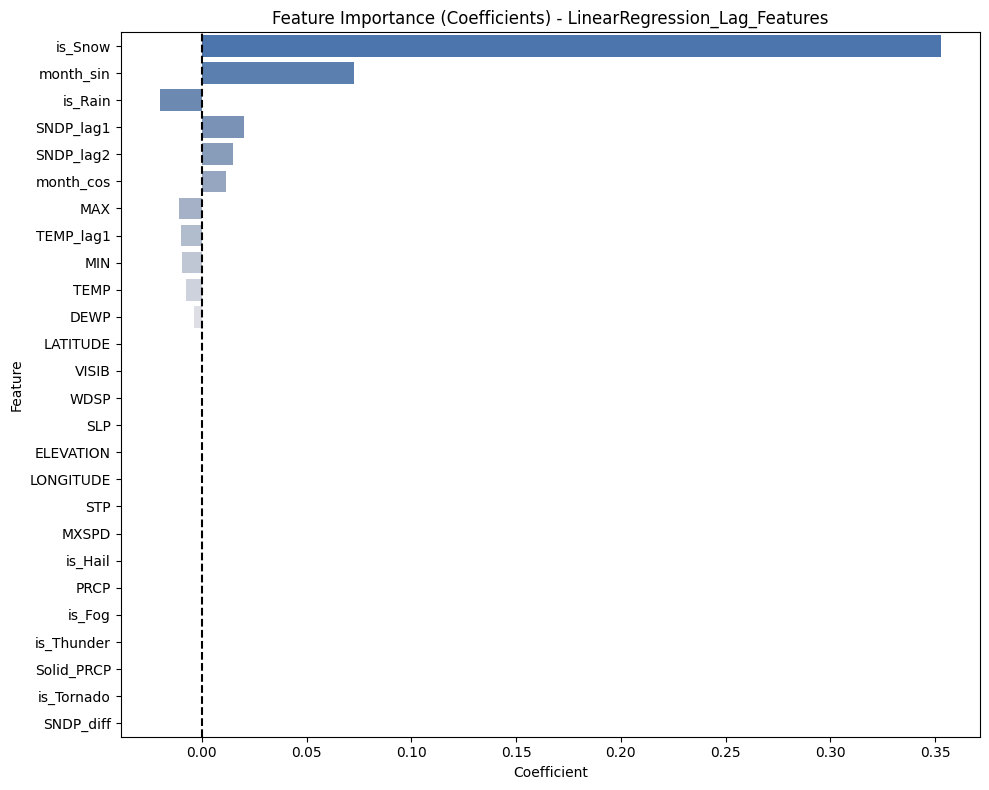


Top 10 Features by Coefficient:
   Feature  Coefficient
   is_Snow     0.352757
 month_sin     0.072777
   is_Rain    -0.020083
 SNDP_lag1     0.019951
 SNDP_lag2     0.015050
 month_cos     0.011608
       MAX    -0.010674
 TEMP_lag1    -0.010039
       MIN    -0.009564
      TEMP    -0.007611
      DEWP    -0.003588
  LATITUDE     0.000237
     VISIB     0.000000
      WDSP     0.000000
       SLP     0.000000
 ELEVATION     0.000000
 LONGITUDE     0.000000
       STP     0.000000
     MXSPD     0.000000
   is_Hail     0.000000
      PRCP     0.000000
    is_Fog     0.000000
is_Thunder     0.000000
Solid_PRCP     0.000000
is_Tornado     0.000000
 SNDP_diff     0.000000
4. Saving model info...
   [v] Spark Model saved to: saved_models/LinearRegression_Lag_Features/spark_model
   [v] Training history saved.
   Generating predictions on Validation Set...



--- METRICS (LinearRegression_Lag_Features) ---
R2: 0.8263 | RMSE: 0.3793 | R2 Snow Only: 0.6486
   Generating plots...


   [v] Plots saved in: saved_models/LinearRegression_Lag_Features

--- PROCESS FINISHED SUCCESSFULLY ---


In [ ]:
MODEL_NAME = "LinearRegression_Lag_Features"

print(f"--- STARTING: {MODEL_NAME} ---")

# Calculate 70-80% of your total physical RAM. 
# Example: If you have 16GB RAM, use 12g for the driver.
TOTAL_RAM = "12g" 

spark = SparkSession.builder \
    .appName(MODEL_NAME) \
    .master("local[*]") \
    .config("spark.driver.memory", TOTAL_RAM) \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.2") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()
    

spark.sparkContext.setLogLevel("ERROR")

model_output_dir = os.path.join(BASE_OUTPUT_DIR, MODEL_NAME)
if os.path.exists(model_output_dir):
    shutil.rmtree(model_output_dir)
os.makedirs(model_output_dir)

print(f"Output Directory: {model_output_dir}")

train_years = range(2010, 2021) 
val_years   = range(2021, 2023) 

print("1. Loading Data (Full Dataset)...")
try:
    train_df = spark.read.parquet(*get_paths(train_years))
    val_df   = spark.read.parquet(*get_paths(val_years))
except Exception as e:
    print(f"Error loading data: {e}")
    spark.stop()
    raise e

target_col = "log_SNDP"
ignore_cols = [target_col, "DATE", "STATION", "NAME", "features", "prediction", "SNDP", "weight"]
valid_types = ['int', 'bigint', 'float', 'double', 'tinyint', 'smallint']

dtypes = train_df.dtypes
feature_cols = [c for c, t in dtypes if t in valid_types and c not in ignore_cols]
print(f"   Features ({len(feature_cols)}): {feature_cols}")

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features").setHandleInvalid("skip")

train_vec = assembler.transform(train_df)
val_vec   = assembler.transform(val_df)

train_vec.persist(StorageLevel.MEMORY_AND_DISK)
print(f"   Training Rows: {train_vec.count():,}")

print(f"2. Training {MODEL_NAME}...")

lr = LinearRegression(
    featuresCol="features", 
    labelCol=target_col,
    weightCol="weight",
    maxIter=50, 
    regParam=0.1, 
    elasticNetParam=0.5
)

start_time = time.time()
model = lr.fit(train_vec)
end_time = time.time()
duration = end_time - start_time

print(f"   Training completed in {duration:.2f} seconds.")

print("3. Processing Results...")

print("Calculating feature importance...")
# 1. Extract coefficients and names of columns
coefficients = model.coefficients.toArray()
attributes = feature_cols

# 2. Create a Pandas DataFrame for easy visualization
importance_df = pd.DataFrame({
    'Feature': attributes,
    'Coefficient': coefficients,
    'Absolute_Coefficient': np.abs(coefficients)
})

# 3. Order by absolute value
importance_df = importance_df.sort_values(by='Absolute_Coefficient', ascending=False)

# 4. Visualize
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=importance_df, palette='vlag', hue='Feature', legend=False)
plt.title(f'Feature Importance (Coefficients) - {MODEL_NAME}')
plt.axvline(x=0, color='black', linestyle='--') # Línea en 0 para ver positivos vs negativos
plt.tight_layout()

# Save graph
plt.savefig(os.path.join(model_output_dir, "feature_importance.png"))
plt.show()

# Show Top 10 
print("\nTop 10 Features by Coefficient:")
print(importance_df[['Feature', 'Coefficient']].to_string(index=False))

print("4. Saving model info...")
model_save_path = os.path.join(model_output_dir, "spark_model")
model.write().overwrite().save(model_save_path)
print(f"   [v] Spark Model saved to: {model_save_path}")

save_training_history(model, model_output_dir, MODEL_NAME)

print("   Generating predictions on Validation Set...")
val_preds = model.transform(val_vec)
metrics = evaluate_and_log(val_preds, target_col, duration, model_output_dir, MODEL_NAME)

plot_predictions(val_preds, target_col, model_output_dir, MODEL_NAME)

print("\n--- PROCESS FINISHED SUCCESSFULLY ---")
train_vec.unpersist()
spark.catalog.clearCache()
spark.stop()

## Decision Tree

--- STARTING: DecisionTree_Lag_Features ---
Output Directory: saved_models/DecisionTree_Lag_Features
1. Loading Data (Full Dataset)...
   Features (26): ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'MAX', 'MIN', 'PRCP', 'is_Fog', 'is_Rain', 'is_Snow', 'is_Hail', 'is_Thunder', 'is_Tornado', 'Solid_PRCP', 'month_sin', 'month_cos', 'SNDP_lag1', 'SNDP_lag2', 'TEMP_lag1', 'SNDP_diff']


   Training Rows: 51,018,114
2. Training DecisionTree_Lag_Features...


   Training completed in 220.54 seconds.
3. Processing Results...
Calculating feature importance...


/tmp/ipykernel_2337/1551702528.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_r')



Top 10 Features by Importance:
   Feature  Importance
 SNDP_lag1    0.996963
       MIN    0.002318
Solid_PRCP    0.000316
 ELEVATION    0.000234
      TEMP    0.000082
 SNDP_diff    0.000052
 LONGITUDE    0.000017
 SNDP_lag2    0.000016
      PRCP    0.000001
  LATITUDE    0.000000
     MXSPD    0.000000
      WDSP    0.000000
     VISIB    0.000000
       STP    0.000000
       SLP    0.000000
      DEWP    0.000000
       MAX    0.000000
    is_Fog    0.000000
is_Thunder    0.000000
   is_Hail    0.000000
   is_Snow    0.000000
   is_Rain    0.000000
 month_cos    0.000000
 month_sin    0.000000
is_Tornado    0.000000
 TEMP_lag1    0.000000
4. Saving model info...
   [v] Spark Model saved to: saved_models/DecisionTree_Lag_Features/spark_model
   [i] Note: DecisionTree_Lag_Features does not produce an iterative convergence plot.
   Generating predictions on Validation Set...



--- METRICS (DecisionTree_Lag_Features) ---
R2: 0.9865 | RMSE: 0.1058 | R2 Snow Only: 0.9479
   Generating plots...


   [v] Plots saved in: saved_models/DecisionTree_Lag_Features

--- PROCESS FINISHED SUCCESSFULLY ---


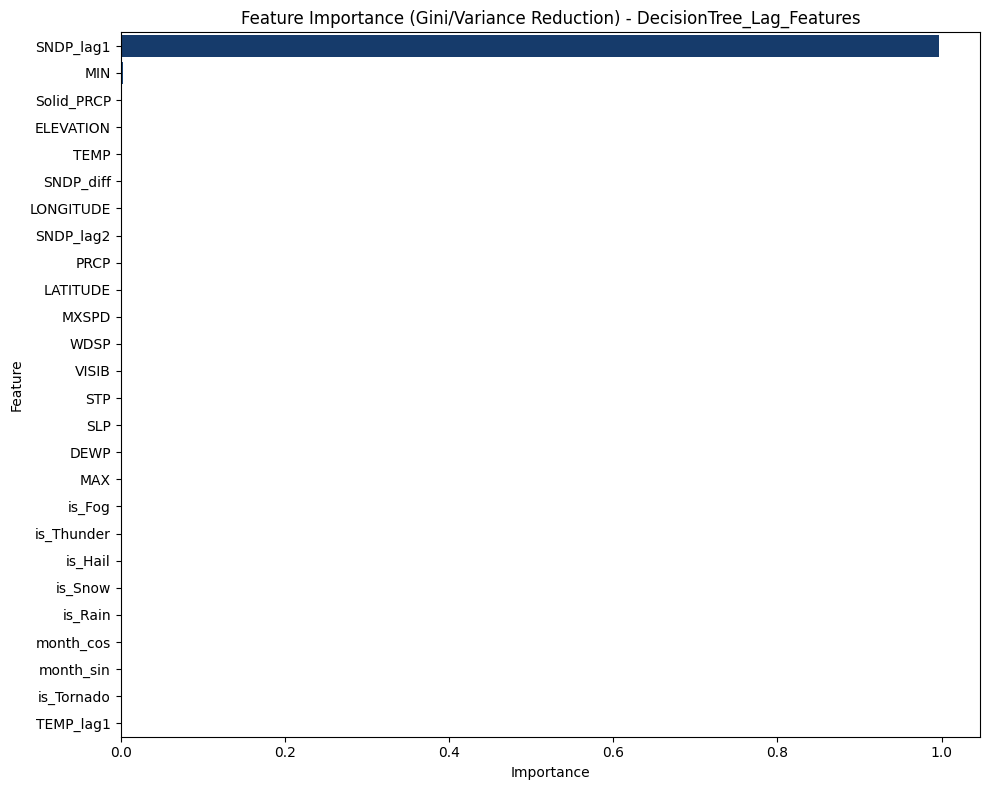

In [4]:
MODEL_NAME = "DecisionTree_Lag_Features"

print(f"--- STARTING: {MODEL_NAME} ---")

# Memory Configuration
TOTAL_RAM = "12g" 

spark = SparkSession.builder \
    .appName(MODEL_NAME) \
    .master("local[*]") \
    .config("spark.driver.memory", TOTAL_RAM) \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.2") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

model_output_dir = os.path.join(BASE_OUTPUT_DIR, MODEL_NAME)
if os.path.exists(model_output_dir):
    shutil.rmtree(model_output_dir)
os.makedirs(model_output_dir)

print(f"Output Directory: {model_output_dir}")

train_years = range(2010, 2021) 
val_years   = range(2021, 2023) 

print("1. Loading Data (Full Dataset)...")
try:
    train_df = spark.read.parquet(*get_paths(train_years))
    val_df   = spark.read.parquet(*get_paths(val_years))
except Exception as e:
    print(f"Error loading data: {e}")
    spark.stop()
    raise e

target_col = "log_SNDP"
ignore_cols = [target_col, "DATE", "STATION", "NAME", "features", "prediction", "SNDP", "weight"]
valid_types = ['int', 'bigint', 'float', 'double', 'tinyint', 'smallint']

dtypes = train_df.dtypes
feature_cols = [c for c, t in dtypes if t in valid_types and c not in ignore_cols]
print(f"   Features ({len(feature_cols)}): {feature_cols}")

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features").setHandleInvalid("skip")

train_vec = assembler.transform(train_df)
val_vec   = assembler.transform(val_df)

train_vec.persist(StorageLevel.MEMORY_AND_DISK)
print(f"   Training Rows: {train_vec.count():,}")

print(f"2. Training {MODEL_NAME}...")

dt = DecisionTreeRegressor(
    featuresCol="features", 
    labelCol=target_col,
    weightCol="weight",
    maxDepth=5,       # Baseline depth, can be increased (e.g., 10) later
    maxBins=32,       # Number of bins for continuous features
    seed=42
)

start_time = time.time()
model = dt.fit(train_vec)
end_time = time.time()
duration = end_time - start_time

print(f"   Training completed in {duration:.2f} seconds.")

print("3. Processing Results...")

print("Calculating feature importance...")
# Decision Trees use 'featureImportances', not 'coefficients'
# featureImportances returns a sparse vector, we convert to dense array
importances = model.featureImportances.toArray()
attributes = feature_cols

# Create a Pandas DataFrame
importance_df = pd.DataFrame({
    'Feature': attributes,
    'Importance': importances
})

# Order by Importance (Desc)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualize
plt.figure(figsize=(10, 8))
# Color palette (blues) better for importances (always positive)
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_r')
plt.title(f'Feature Importance (Gini/Variance Reduction) - {MODEL_NAME}')
plt.tight_layout()

# Save graph
plt.savefig(os.path.join(model_output_dir, "feature_importance.png"))
# plt.show() # Commented out for server safety

# Show Top 10 
print("\nTop 10 Features by Importance:")
print(importance_df[['Feature', 'Importance']].to_string(index=False))

print("4. Saving model info...")
model_save_path = os.path.join(model_output_dir, "spark_model")
model.write().overwrite().save(model_save_path)
print(f"   [v] Spark Model saved to: {model_save_path}")

# This will print a message saying DT doesn't support history plots
save_training_history(model, model_output_dir, MODEL_NAME)

print("   Generating predictions on Validation Set...")
val_preds = model.transform(val_vec)
metrics = evaluate_and_log(val_preds, target_col, duration, model_output_dir, MODEL_NAME)

plot_predictions(val_preds, target_col, model_output_dir, MODEL_NAME)

print("\n--- PROCESS FINISHED SUCCESSFULLY ---")
train_vec.unpersist()
spark.catalog.clearCache()
spark.stop()

## Random Forest

--- STARTING: RandomForest_Lag_Features ---


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/07 13:27:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Output Directory: saved_models/RandomForest_Lag_Features
1. Loading Data (Full Dataset)...


   Features (26): ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'MAX', 'MIN', 'PRCP', 'is_Fog', 'is_Rain', 'is_Snow', 'is_Hail', 'is_Thunder', 'is_Tornado', 'Solid_PRCP', 'month_sin', 'month_cos', 'SNDP_lag1', 'SNDP_lag2', 'TEMP_lag1', 'SNDP_diff']


   Training Rows: 51,018,114
2. Training RandomForest_Lag_Features...


   Training completed in 547.20 seconds.
3. Processing Results...
Calculating feature importance...


/tmp/ipykernel_2304/3916583001.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Greens_r') # Using Greens for Forest



Top 10 Features by Importance:
   Feature   Importance
 SNDP_lag2 4.885081e-01
 SNDP_lag1 2.500594e-01
      TEMP 1.220012e-01
 TEMP_lag1 7.825303e-02
       MAX 4.304759e-02
       MIN 1.072982e-02
 SNDP_diff 2.034450e-03
 month_sin 1.859824e-03
  LATITUDE 1.264564e-03
   is_Snow 9.803221e-04
Solid_PRCP 4.589042e-04
 ELEVATION 3.319806e-04
 month_cos 2.574112e-04
      DEWP 1.151018e-04
      PRCP 4.772556e-05
 LONGITUDE 2.108283e-05
     MXSPD 1.517820e-05
       SLP 6.512471e-06
       STP 3.406109e-06
     VISIB 2.821637e-06
   is_Rain 1.363345e-06
is_Thunder 8.901422e-08
      WDSP 0.000000e+00
    is_Fog 0.000000e+00
   is_Hail 0.000000e+00
is_Tornado 0.000000e+00
4. Saving model info...
   [v] Spark Model saved to: saved_models/RandomForest_Lag_Features/spark_model
   [i] Note: RandomForest_Lag_Features does not produce an iterative convergence plot.
   Generating predictions on Validation Set...



--- METRICS (RandomForest_Lag_Features) ---
R2: 0.9845 | RMSE: 0.1134 | R2 Snow Only: 0.9356
   Generating plots...


   [v] Plots saved in: saved_models/RandomForest_Lag_Features

--- PROCESS FINISHED SUCCESSFULLY ---


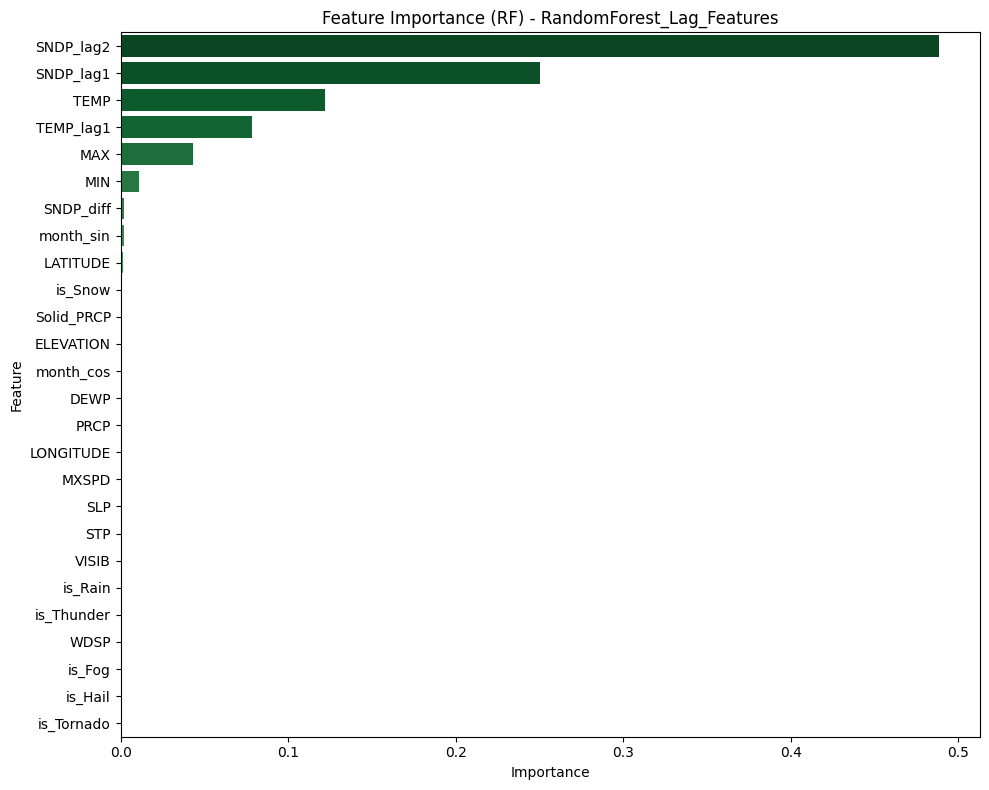

In [3]:
MODEL_NAME = "RandomForest_Lag_Features"

print(f"--- STARTING: {MODEL_NAME} ---")

# Memory Configuration
TOTAL_RAM = "12g" 

spark = SparkSession.builder \
    .appName(MODEL_NAME) \
    .master("local[*]") \
    .config("spark.driver.memory", TOTAL_RAM) \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.2") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

model_output_dir = os.path.join(BASE_OUTPUT_DIR, MODEL_NAME)
if os.path.exists(model_output_dir):
    shutil.rmtree(model_output_dir)
os.makedirs(model_output_dir)

print(f"Output Directory: {model_output_dir}")

train_years = range(2010, 2021) 
val_years   = range(2021, 2023) 

print("1. Loading Data (Full Dataset)...")
try:
    train_df = spark.read.parquet(*get_paths(train_years))
    val_df   = spark.read.parquet(*get_paths(val_years))
except Exception as e:
    print(f"Error loading data: {e}")
    spark.stop()
    raise e

target_col = "log_SNDP"
ignore_cols = [target_col, "DATE", "STATION", "NAME", "features", "prediction", "SNDP", "weight"]
valid_types = ['int', 'bigint', 'float', 'double', 'tinyint', 'smallint']

dtypes = train_df.dtypes
feature_cols = [c for c, t in dtypes if t in valid_types and c not in ignore_cols]
print(f"   Features ({len(feature_cols)}): {feature_cols}")

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features").setHandleInvalid("skip")

train_vec = assembler.transform(train_df)
val_vec   = assembler.transform(val_df)

train_vec.persist(StorageLevel.MEMORY_AND_DISK)
print(f"   Training Rows: {train_vec.count():,}")

print(f"2. Training {MODEL_NAME}...")

# CHANGED: Using RandomForestRegressor
rf = RandomForestRegressor(
    featuresCol="features", 
    labelCol=target_col,
    weightCol="weight",
    numTrees=20,      # Number of trees (can be increased to 50 or 100 later)
    maxDepth=5,       # Baseline depth
    maxBins=32,       # Number of bins for continuous features
    seed=42
)

start_time = time.time()
model = rf.fit(train_vec)
end_time = time.time()
duration = end_time - start_time

print(f"   Training completed in {duration:.2f} seconds.")

print("3. Processing Results...")

print("Calculating feature importance...")
# Random Forests also use 'featureImportances', same as Decision Trees
importances = model.featureImportances.toArray()
attributes = feature_cols

# Create a Pandas DataFrame
importance_df = pd.DataFrame({
    'Feature': attributes,
    'Importance': importances
})

# Order by Importance (Desc)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualize
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Greens_r') # Using Greens for Forest
plt.title(f'Feature Importance (RF) - {MODEL_NAME}')
plt.tight_layout()

# Save graph
plt.savefig(os.path.join(model_output_dir, "feature_importance.png"))
# plt.show() 

# Show Top 10 
print("\nTop 10 Features by Importance:")
print(importance_df[['Feature', 'Importance']].to_string(index=False))

print("4. Saving model info...")
model_save_path = os.path.join(model_output_dir, "spark_model")
model.write().overwrite().save(model_save_path)
print(f"   [v] Spark Model saved to: {model_save_path}")

save_training_history(model, model_output_dir, MODEL_NAME)

print("   Generating predictions on Validation Set...")
val_preds = model.transform(val_vec)
metrics = evaluate_and_log(val_preds, target_col, duration, model_output_dir, MODEL_NAME)

plot_predictions(val_preds, target_col, model_output_dir, MODEL_NAME)

print("\n--- PROCESS FINISHED SUCCESSFULLY ---")
train_vec.unpersist()
spark.catalog.clearCache()
spark.stop()

## GBT Regressor

--- STARTING: GBT_Lag_Features ---


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/07 13:46:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Output Directory: saved_models/GBT_Lag_Features
1. Loading Data (Full Dataset)...


   Features (26): ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'MAX', 'MIN', 'PRCP', 'is_Fog', 'is_Rain', 'is_Snow', 'is_Hail', 'is_Thunder', 'is_Tornado', 'Solid_PRCP', 'month_sin', 'month_cos', 'SNDP_lag1', 'SNDP_lag2', 'TEMP_lag1', 'SNDP_diff']


   Training Rows: 51,018,114
2. Training GBT_Lag_Features...


   Training completed in 2089.47 seconds.
3. Processing Results...
Calculating feature importance...


/tmp/ipykernel_2591/2839889826.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Oranges_r')



Top 10 Features by Importance:
   Feature  Importance
 SNDP_lag1    0.980666
       MIN    0.003908
 SNDP_diff    0.003280
 SNDP_lag2    0.002457
 TEMP_lag1    0.002100
      TEMP    0.001485
Solid_PRCP    0.001247
      PRCP    0.001123
       MAX    0.001029
 LONGITUDE    0.000644
 ELEVATION    0.000532
  LATITUDE    0.000397
      DEWP    0.000275
   is_Snow    0.000251
   is_Rain    0.000167
       STP    0.000116
 month_cos    0.000098
 month_sin    0.000094
       SLP    0.000087
     VISIB    0.000018
     MXSPD    0.000016
      WDSP    0.000012
is_Thunder    0.000000
   is_Hail    0.000000
    is_Fog    0.000000
is_Tornado    0.000000
4. Saving model info...
   [v] Spark Model saved to: saved_models/GBT_Lag_Features/spark_model
   [i] Note: GBT_Lag_Features does not produce an iterative convergence plot.
   Generating predictions on Validation Set...



--- METRICS (GBT_Lag_Features) ---
R2: 0.9890 | RMSE: 0.0953 | R2 Snow Only: 0.9523
   Generating plots...


   [v] Plots saved in: saved_models/GBT_Lag_Features

--- PROCESS FINISHED SUCCESSFULLY ---


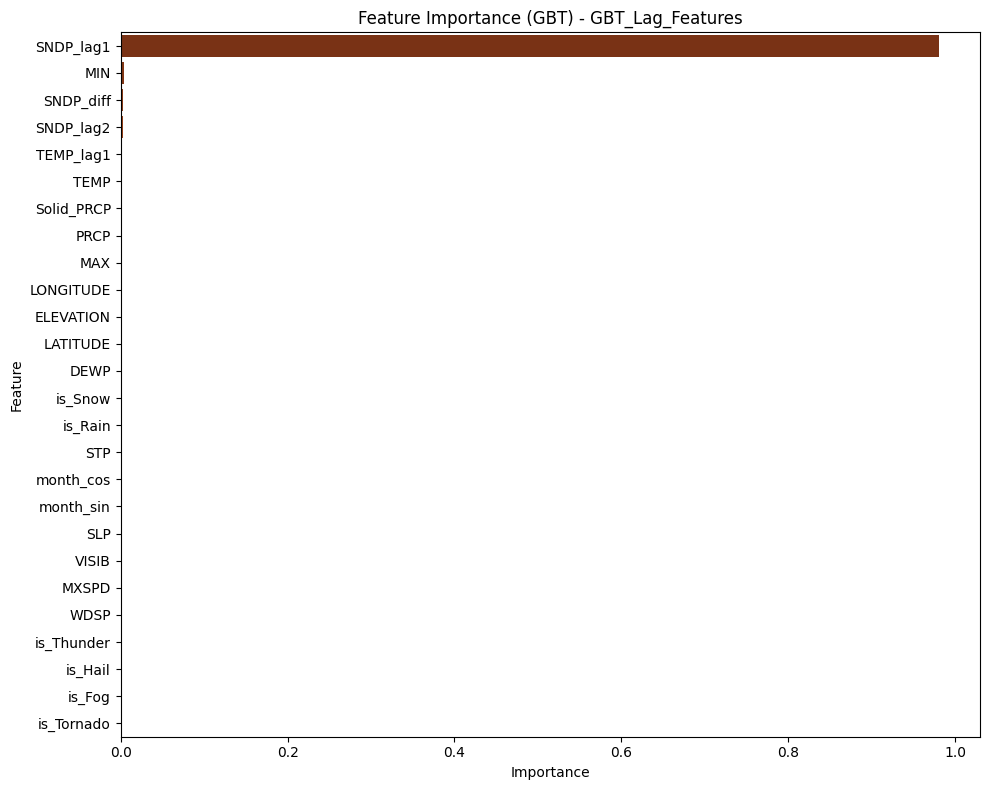

In [3]:
MODEL_NAME = "GBT_Lag_Features"

print(f"--- STARTING: {MODEL_NAME} ---")

# Memory Configuration
TOTAL_RAM = "12g" 

spark = SparkSession.builder \
    .appName(MODEL_NAME) \
    .master("local[*]") \
    .config("spark.driver.memory", TOTAL_RAM) \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.2") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

model_output_dir = os.path.join(BASE_OUTPUT_DIR, MODEL_NAME)
if os.path.exists(model_output_dir):
    shutil.rmtree(model_output_dir)
os.makedirs(model_output_dir)

print(f"Output Directory: {model_output_dir}")

train_years = range(2010, 2021) 
val_years   = range(2021, 2023) 

print("1. Loading Data (Full Dataset)...")
try:
    train_df = spark.read.parquet(*get_paths(train_years))
    val_df   = spark.read.parquet(*get_paths(val_years))
except Exception as e:
    print(f"Error loading data: {e}")
    spark.stop()
    raise e

target_col = "log_SNDP"
ignore_cols = [target_col, "DATE", "STATION", "NAME", "features", "prediction", "SNDP", "weight"]
valid_types = ['int', 'bigint', 'float', 'double', 'tinyint', 'smallint']

dtypes = train_df.dtypes
feature_cols = [c for c, t in dtypes if t in valid_types and c not in ignore_cols]
print(f"   Features ({len(feature_cols)}): {feature_cols}")

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features").setHandleInvalid("skip")

train_vec = assembler.transform(train_df)
val_vec   = assembler.transform(val_df)

train_vec.persist(StorageLevel.MEMORY_AND_DISK)
print(f"   Training Rows: {train_vec.count():,}")

print(f"2. Training {MODEL_NAME}...")

# CHANGED: Using GBTRegressor
# GBTs are sequential and take longer than RF to train. Keeping maxIter low (10) for the baseline.
gbt = GBTRegressor(
    featuresCol="features", 
    labelCol=target_col,
    weightCol="weight",
    maxIter=20,       # Number of boosting rounds (trees)
    maxDepth=5,       # Depth of each tree
    maxBins=32,       # Number of bins for continuous features
    seed=42
)

start_time = time.time()
model = gbt.fit(train_vec)
end_time = time.time()
duration = end_time - start_time

print(f"   Training completed in {duration:.2f} seconds.")

print("3. Processing Results...")

print("Calculating feature importance...")
# GBT also uses 'featureImportances'
importances = model.featureImportances.toArray()
attributes = feature_cols

# Create a Pandas DataFrame
importance_df = pd.DataFrame({
    'Feature': attributes,
    'Importance': importances
})

# Order by Importance (Desc)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Visualize
plt.figure(figsize=(10, 8))
# Using Oranges for GBT to distinguish from RF (Green) and Linear (Blue/Red)
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Oranges_r')
plt.title(f'Feature Importance (GBT) - {MODEL_NAME}')
plt.tight_layout()

# Save graph
plt.savefig(os.path.join(model_output_dir, "feature_importance.png"))
# plt.show() 

# Show Top 10 
print("\nTop 10 Features by Importance:")
print(importance_df[['Feature', 'Importance']].to_string(index=False))

print("4. Saving model info...")
model_save_path = os.path.join(model_output_dir, "spark_model")
model.write().overwrite().save(model_save_path)
print(f"   [v] Spark Model saved to: {model_save_path}")

save_training_history(model, model_output_dir, MODEL_NAME)

print("   Generating predictions on Validation Set...")
val_preds = model.transform(val_vec)
metrics = evaluate_and_log(val_preds, target_col, duration, model_output_dir, MODEL_NAME)

plot_predictions(val_preds, target_col, model_output_dir, MODEL_NAME)

print("\n--- PROCESS FINISHED SUCCESSFULLY ---")
train_vec.unpersist()
spark.catalog.clearCache()
spark.stop()

# Comparison

In [4]:
import json
import pandas as pd
from pathlib import Path

BASE_DIR = Path("saved_models")

rows = []

for model_dir in BASE_DIR.iterdir():
    metrics_path = model_dir / "metrics.json"
    if metrics_path.exists():
        with open(metrics_path) as f:
            data = json.load(f)
            rows.append(data)

df = pd.DataFrame(rows)
df = df.sort_values("Model")
df

,Model,Time_Sec,R2_Global,RMSE_Global,MAE_Global,R2_Snow_Only
5,DecisionTree_Baseline,127.17,0.4996,8.4388,1.9734,0.1591
3,DecisionTree_Lag_Features,220.54,0.9865,0.1058,0.0183,0.9479
0,GBT_Baseline,1576.90,0.5451,8.0461,1.8859,0.2347
6,GBT_Lag_Features,2089.47,0.9890,0.0953,0.0170,0.9523
1,LinearRegression_Baseline,41.82,0.3613,9.5340,4.2187,0.0218
7,LinearRegression_Lag_Features,58.59,0.8263,0.3793,0.2881,0.6486
2,RandomForest_Baseline,441.75,0.5048,8.3946,1.9914,0.1659
4,RandomForest_Lag_Features,547.20,0.9845,0.1134,0.0240,0.9356


In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_r2_metrics(df):
    metrics = ["R2_Global", "R2_Snow_Only"]
    labels = {
        "R2_Global": "R2 Global",
        "R2_Snow_Only": "R2 Snow Only"
    }

    models = df["Model"].values
    x = np.arange(len(models))
    width = 0.35

    plt.figure(figsize=(14, 6))

    for i, metric in enumerate(metrics):
        values = df[metric].values
        bars = plt.bar(
            x + i * width,
            values,
            width,
            label=labels[metric]
        )

        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height:.2f}",
                ha="center",
                va="bottom",
                fontsize=9
            )

    plt.xticks(x + width / 2, models, rotation=45, ha="right")
    plt.ylabel("R²")
    plt.title("Model Comparison — R² Metrics")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_error_metrics(df):
    metrics = ["RMSE_Global", "MAE_Global"]
    labels = {
        "RMSE_Global": "RMSE",
        "MAE_Global": "MAE"
    }

    colors = {
        "RMSE_Global": "tab:green",
        "MAE_Global": "tab:red"
    }

    models = df["Model"].values
    x = np.arange(len(models))
    width = 0.35

    plt.figure(figsize=(14, 6))

    for i, metric in enumerate(metrics):
        values = df[metric].values
        bars = plt.bar(
            x + i * width,
            values,
            width,
            label=labels[metric],
            color=colors[metric] 
        )

        for bar in bars:
            height = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height:.2f}",
                ha="center",
                va="bottom",
                fontsize=9
            )

    plt.xticks(x + width / 2, models, rotation=45, ha="right")
    plt.ylabel("Error")
    plt.title("Model Comparison — Error Metrics")
    plt.legend()
    plt.tight_layout()
    plt.show()



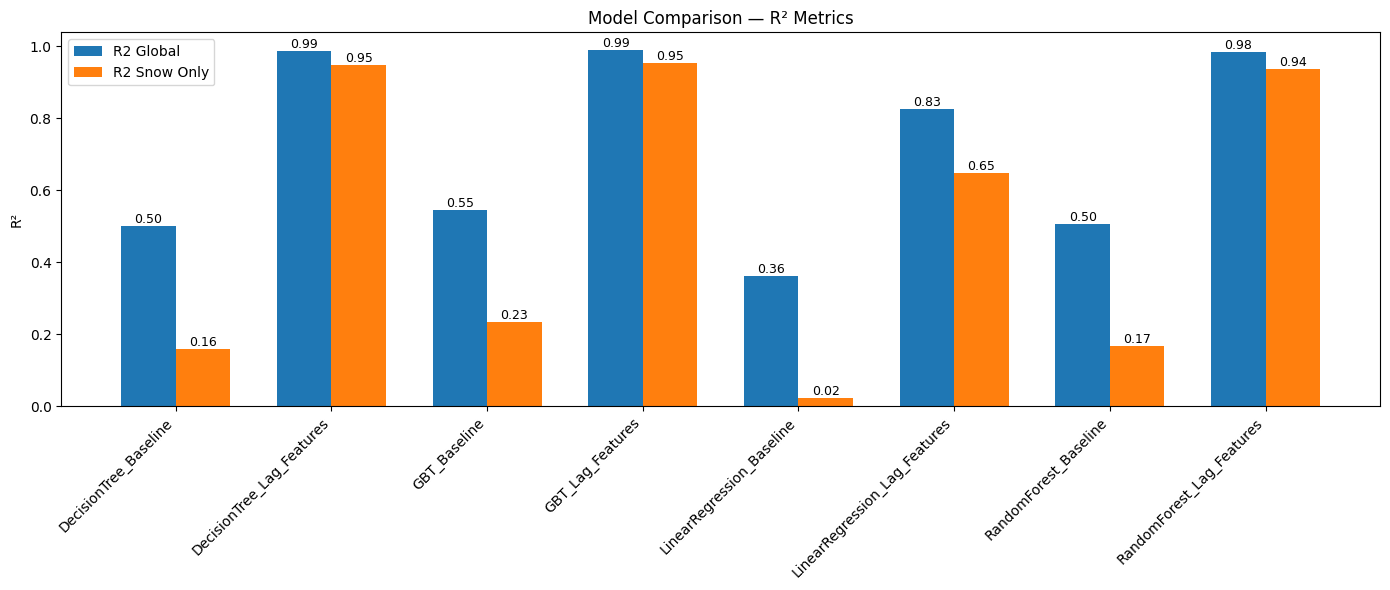

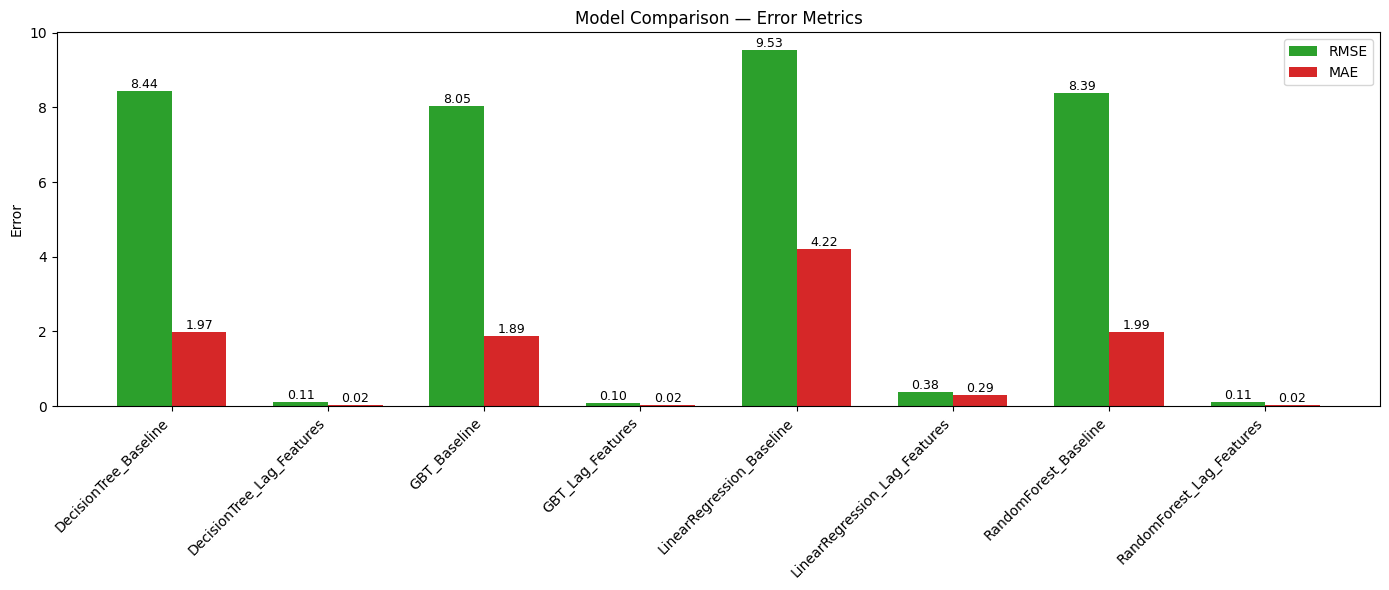

In [19]:
plot_r2_metrics(df)
plot_error_metrics(df)



In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def compare_prediction_plots(model_names, ncols=2):
    nrows = (len(model_names) + ncols - 1) // ncols
    plt.figure(figsize=(8 * ncols, 4 * nrows))

    for i, model in enumerate(model_names, 1):
        img_path = Path("saved_models") / model / "prediction_plots.png"
        img = mpimg.imread(img_path)

        plt.subplot(nrows, ncols, i)
        plt.imshow(img)
        plt.title(model)
        plt.axis("off")

    plt.tight_layout()
    plt.show()



=== LinearRegression: Baseline vs Lag Features ===


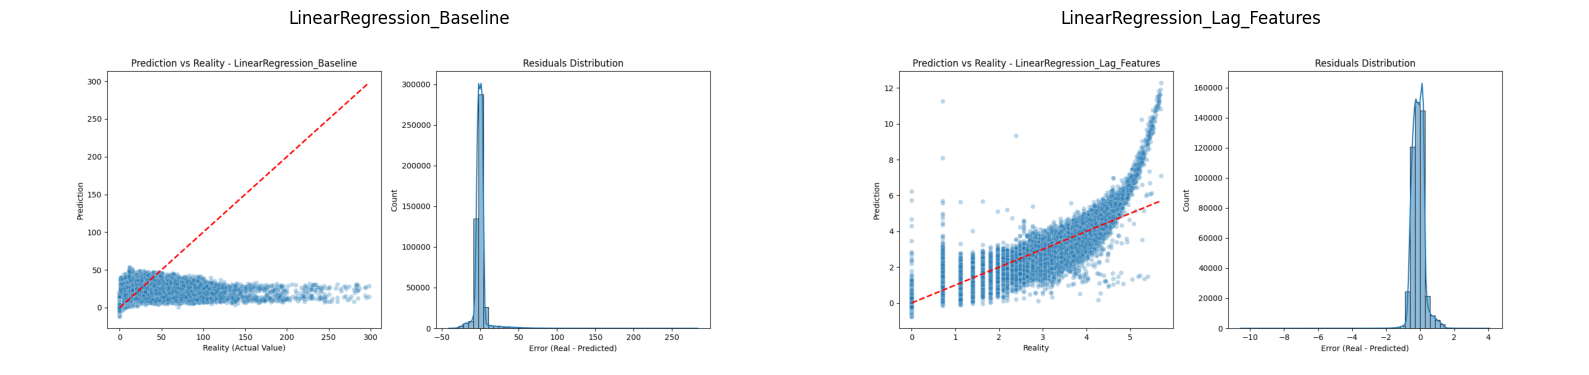


=== DecisionTree: Baseline vs Lag Features ===


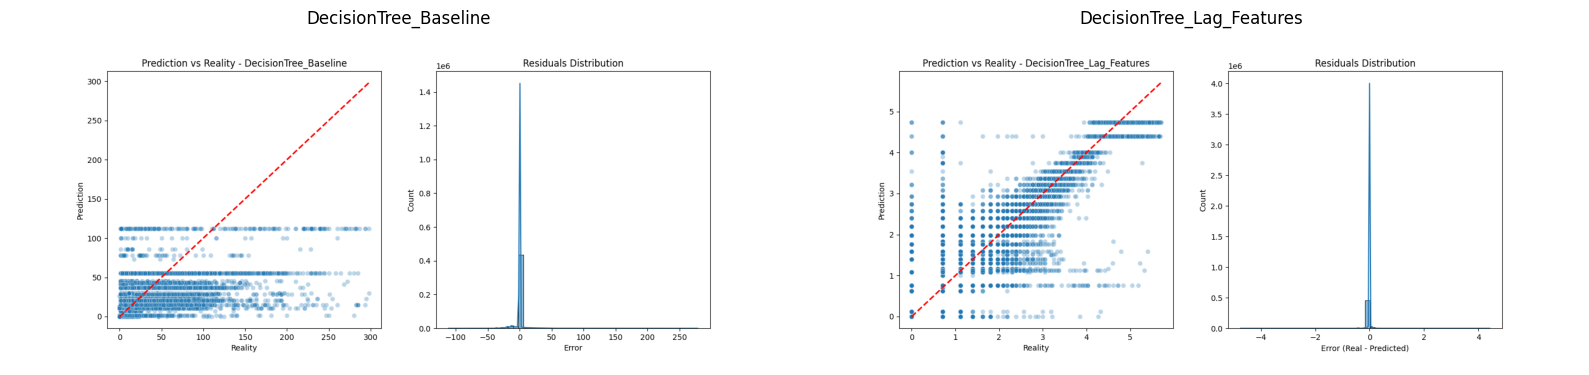


=== RandomForest: Baseline vs Lag Features ===


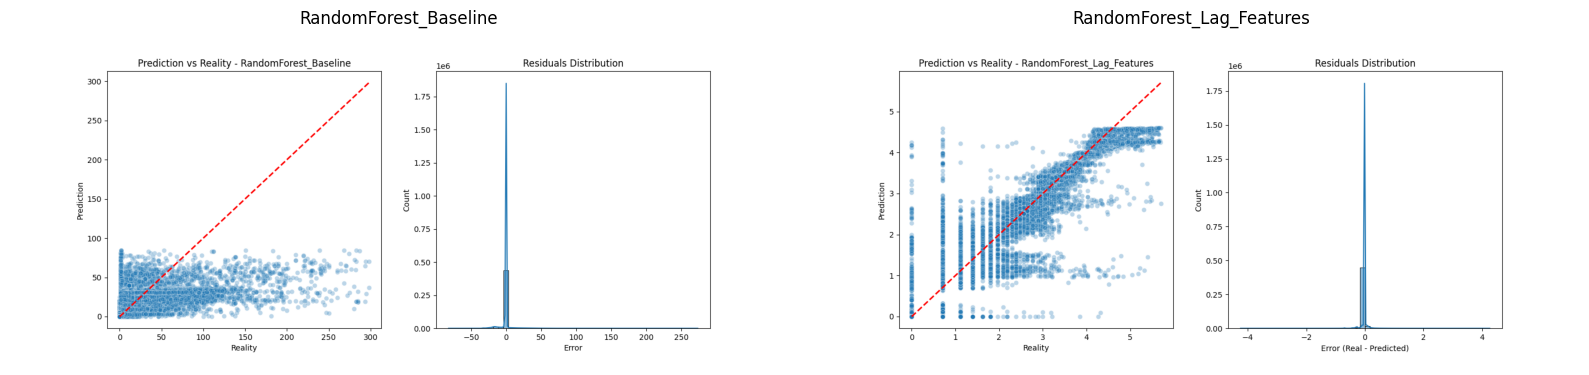


=== GBT: Baseline vs Lag Features ===


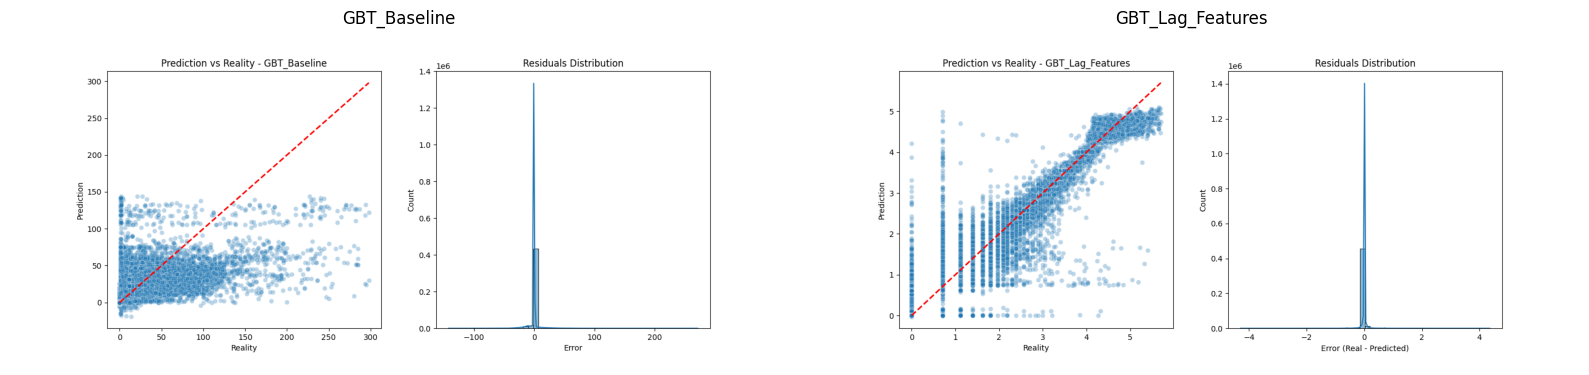

In [7]:
# Baseline vs Lag
model_families = [
    "LinearRegression",
    "DecisionTree",
    "RandomForest",
    "GBT"
]
for model in model_families:
    print(f"\n=== {model}: Baseline vs Lag Features ===")
    compare_prediction_plots(
        [
            f"{model}_Baseline",
            f"{model}_Lag_Features"
        ],
        ncols=2
    )


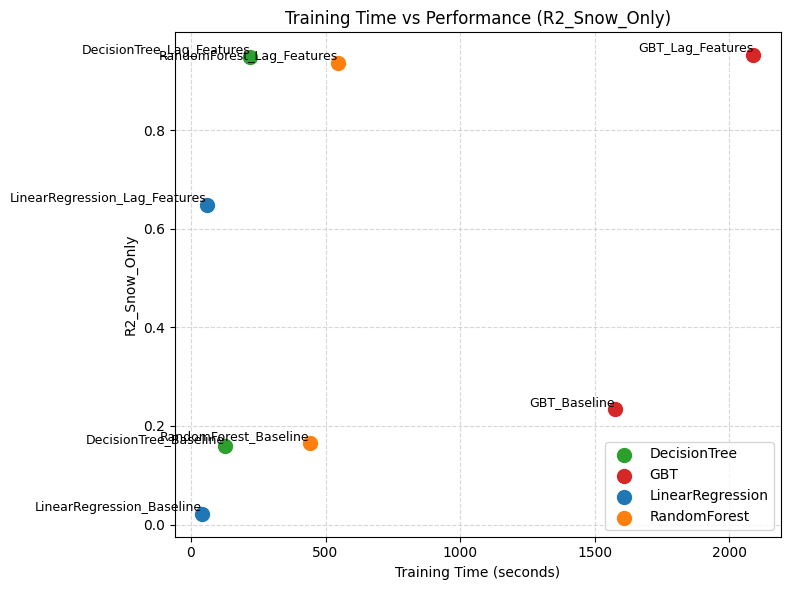

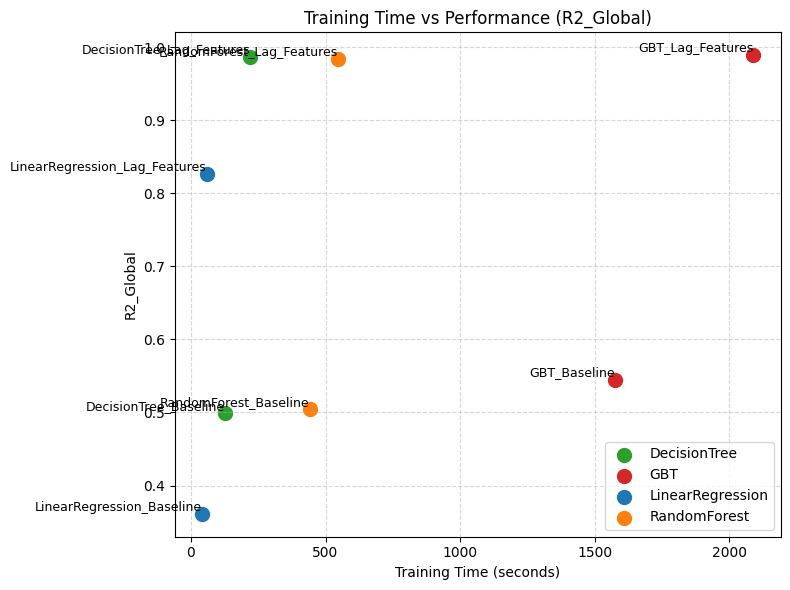

In [22]:
import matplotlib.pyplot as plt

def plot_time_vs_performance(df, perf_metric):
    families = {
        "LinearRegression": "tab:blue",
        "DecisionTree": "tab:green",
        "RandomForest": "tab:orange",
        "GBT": "tab:red"
    }

    plt.figure(figsize=(8, 6))

    for _, row in df.iterrows():
        family = row["Model"].split("_")[0]
        plt.scatter(
            row["Time_Sec"],
            row[perf_metric],
            color=families.get(family, "gray"),
            s=100,
            label=family
        )
        plt.text(
            row["Time_Sec"],
            row[perf_metric],
            row["Model"],
            fontsize=9,
            ha="right",
            va="bottom"
        )

    plt.xlabel("Training Time (seconds)")
    plt.ylabel(perf_metric)
    plt.title(f"Training Time vs Performance ({perf_metric})")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()



plot_time_vs_performance(df, "R2_Snow_Only")
plot_time_vs_performance(df, "R2_Global")


## Hypertuning of Random Forest

In [3]:
# BASE_OUTPUT_DIR = "optimized_models"     
# MASTER_LOG_FILE = "tuning_comparison.csv" 
# BASE_DATA_PATH = "processed_data"    

# def get_paths(years):
#     return [f"{BASE_DATA_PATH}/climate_{y}.parquet" for y in years]

# def save_best_params(cv_model, output_dir):
#     """
#     Extracts and saves the best hyperparameters found by CrossValidator.
#     """
#     rf_model = cv_model.bestModel
    
#     params = {
#         "numTrees": rf_model.getNumTrees,
#         "maxDepth": rf_model.getOrDefault("maxDepth"),
#         "maxBins": rf_model.getOrDefault("maxBins"),
#         "subsamplingRate": rf_model.getOrDefault("subsamplingRate")
#     }
    
#     with open(os.path.join(output_dir, "best_params.json"), 'w') as f:
#         json.dump(params, f, indent=4)
    
#     print("\n   [v] WINNING PARAMETERS SAVED:")
#     print(json.dumps(params, indent=4))

# def evaluate_and_log(predictions, target_col, time_taken, output_dir, model_name):
#     """
#     Evaluates the model on the final Test set.
#     """
#     evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction")
    
#     r2 = evaluator.setMetricName("r2").evaluate(predictions)
#     rmse = evaluator.setMetricName("rmse").evaluate(predictions)
    
#     snow_subset = predictions.filter(col(target_col) > 0)
#     r2_snow = evaluator.setMetricName("r2").evaluate(snow_subset) if snow_subset.count() > 0 else 0.0

#     metrics = {
#         "Model": model_name,
#         "Time_Min": round(time_taken / 60, 2),
#         "R2_Global": round(r2, 4),
#         "RMSE_Global": round(rmse, 4),
#         "R2_Snow_Only": round(r2_snow, 4)
#     }

#     file_exists = os.path.isfile(MASTER_LOG_FILE)
#     with open(MASTER_LOG_FILE, mode='a', newline='') as file:
#         writer = csv.DictWriter(file, fieldnames=metrics.keys())
#         if not file_exists:
#             writer.writeheader()
#         writer.writerow(metrics)

#     print(f"\n--- FINAL TEST RESULTS ({model_name}) ---")
#     print(f"R2 Global: {r2:.4f} | R2 Snow Only: {r2_snow:.4f}")
#     return metrics

In [ ]:
# MODEL_NAME = "RandomForest_HyperTuning"
# print(f"--- STARTING TUNING: {MODEL_NAME} ---")

# spark = SparkSession.builder \
#     .appName(MODEL_NAME) \
#     .master("local[*]") \
#     .config("spark.driver.memory", "12g") \
#     .config("spark.executor.memory", "12g") \
#     .config("spark.sql.files.maxPartitionBytes", "128m") \
#     .config("spark.driver.maxResultSize", "4g") \
#     .getOrCreate()

# spark.sparkContext.setLogLevel("ERROR")

# model_output_dir = os.path.join(BASE_OUTPUT_DIR, MODEL_NAME)
# if os.path.exists(model_output_dir):
#     shutil.rmtree(model_output_dir)
# os.makedirs(model_output_dir)

# train_years = range(2010, 2021) 
# val_years   = range(2021, 2023) 
# test_years  = range(2023, 2025) 

# print("1. Loading and Transforming Data...")
# train_raw = spark.read.parquet(*get_paths(train_years))
# val_raw  = spark.read.parquet(*get_paths(val_years))

# def add_features(df):
#     df = df.withColumn("MONTH", month(col("DATE")))
#     df = df.withColumn("Solid_PRCP", when((col("PRCP") > 0) & (col("TEMP") < 2.0), col("PRCP")).otherwise(0.0))
#     return df

# train_df = add_features(train_raw)
# val_df  = add_features(val_raw)

# target_col = "SNDP"
# ignore_cols = [target_col, "DATE", "STATION", "NAME", "features", "prediction", "FRSHTT"]
# valid_types = ['int', 'bigint', 'float', 'double', 'tinyint', 'smallint']

# dtypes = train_df.dtypes
# feature_cols = [c for c, t in dtypes if t in valid_types and c not in ignore_cols]
# print(f"   Features to use: {feature_cols}")

# assembler = VectorAssembler(inputCols=feature_cols, outputCol="features").setHandleInvalid("skip")

# train_vec = assembler.transform(train_df)
# val_vec  = assembler.transform(val_df)

# train_vec.persist(StorageLevel.MEMORY_AND_DISK)
# print(f"   Training Rows (Internal Train + Val): {train_vec.count():,}")

# print("2. Configuring Grid Search...")

# print(f"   Original Training Rows: {train_vec.count():,}")

# # # --- ADD THIS SAMPLING STEP ---
# # # Take 10% of data for the heavy tuning process
# # train_vec_sample = train_vec.sample(False, 0.2, seed=42) 
# # train_vec_sample.persist(StorageLevel.MEMORY_AND_DISK)

# # print(f"   Tuning Sample Rows: {train_vec_sample.count():,}")

# rf = RandomForestRegressor(featuresCol="features", labelCol=target_col, seed=42)

# paramGrid = ParamGridBuilder() \
#     .addGrid(rf.numTrees, [50, 25]) \
#     .addGrid(rf.maxDepth, [15, 10]) \
#     .build()
#     # .addGrid(rf.maxBins, [32, 64]) \

# print(f"   Combinations to test: {len(paramGrid)}")

# evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction", metricName="rmse")

# # tvs = TrainValidationSplit(
# #     estimator=rf,
# #     estimatorParamMaps=paramGrid,
# #     evaluator=evaluator,
# #     trainRatio=0.8,
# #     parallelism=1
# # )


# # print("3. Running Train-Validation Split (Please wait)...")
# # start_time = time.time()

# # cv_model = tvs.fit(train_vec)

# # end_time = time.time()
# # duration = end_time - start_time
# # print(f"   Tuning completed in {duration/60:.2f} minutes!")

# # print("4. Analyzing the Champion Model...")

# # best_model = cv_model.bestModel

# print("3. Running Time-Aware Hyperparameter Search...")
# start_time = time.time()

# results = []

# for i, param_map in enumerate(paramGrid, 1):
#     print(f"   [{i}/{len(paramGrid)}] Training with params: "
#           f"numTrees={param_map[rf.numTrees]}, "
#           f"maxDepth={param_map[rf.maxDepth]}")

#     # Train ONLY on past data
#     model = rf.copy(param_map).fit(train_vec)

#     # Validate ONLY on future data
#     val_preds = model.transform(val_vec)
#     rmse = evaluator.evaluate(val_preds)

#     print(f"       RMSE = {rmse:.4f}")

#     results.append({
#         "numTrees": param_map[rf.numTrees],
#         "maxDepth": param_map[rf.maxDepth],
#         "rmse": rmse,
#         "model": model
#     })

# end_time = time.time()
# duration = end_time - start_time

# print(f"   Tuning completed in {duration/60:.2f} minutes!")

# best_result = min(results, key=lambda x: x["rmse"])
# best_model = best_result["model"]

# print("\n4. Best Model Selected:")
# print(f"   numTrees = {best_result['numTrees']}")
# print(f"   maxDepth = {best_result['maxDepth']}")
# print(f"   RMSE     = {best_result['rmse']:.4f}")

# best_model.write().overwrite().save(
#     os.path.join(model_output_dir, "spark_model_winner")
# )

# save_best_params(best_result, model_output_dir)

# print("\n--- PROCESS FINISHED ---")
# spark.stop()

--- STARTING TUNING: RandomForest_HyperTuning ---
1. Loading and Transforming Data...


   Features to use: ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'MAX', 'MIN', 'PRCP', 'is_Fog', 'is_Rain', 'is_Snow', 'is_Hail', 'is_Thunder', 'is_Tornado', 'MONTH', 'Solid_PRCP']


   Training Rows (Internal Train + Val): 51,241,804
2. Configuring Grid Search...


   Original Training Rows: 51,241,804
   Combinations to test: 4
3. Running Time-Aware Hyperparameter Search...
   [1/4] Training with params: numTrees=50, maxDepth=15


       RMSE = 6.4939
   [2/4] Training with params: numTrees=50, maxDepth=10


## Lag Variables

In [9]:
# def add_lag_features(df):
#     # Definimos la ventana: misma estación, ordenada por tiempo
#     window_spec = Window.partitionBy("STATION").orderBy("DATE")
    
#     # 1. Retardo de la variable objetivo (SNDP)
#     # Usamos SNDP original antes del log para que el modelo entienda la escala real
#     df = df.withColumn("SNDP_lag1", sql_f.lag("SNDP", 1).over(window_spec))
#     df = df.withColumn("SNDP_lag2", sql_f.lag("SNDP", 2).over(window_spec))
    
#     # 2. Retardo de Temperatura (Persistencia térmica)
#     # Asumiendo que tienes una columna 'TEMP'
#     if "TEMP" in df.columns:
#         df = df.withColumn("TEMP_lag1", sql_f.lag("TEMP", 1).over(window_spec))
    
#     # 3. Diferencia de nieve (Delta) - Indica si está acumulando o derritiendo
#     df = df.withColumn("SNDP_diff", sql_f.col("SNDP_lag1") - sql_f.col("SNDP_lag2"))
    
#     # IMPORTANTE: Al crear LAGS, las primeras filas de cada estación tendrán NULLS
#     # Debemos eliminarlas o imputarlas para que el VectorAssembler no falle
#     return df.dropna(subset=["SNDP_lag1", "SNDP_lag2"])

In [11]:
# MODEL_NAME = "RandomForest_Lag_Features"

# print(f"--- STARTING: {MODEL_NAME} ---")

# # Calculate 70-80% of your total physical RAM. 
# # Example: If you have 16GB RAM, use 12g for the driver.
# TOTAL_RAM = "12g" 

# spark = SparkSession.builder \
#     .appName(MODEL_NAME) \
#     .master("local[*]") \
#     .config("spark.driver.memory", TOTAL_RAM) \
#     .config("spark.driver.maxResultSize", "4g") \
#     .config("spark.memory.fraction", "0.8") \
#     .config("spark.memory.storageFraction", "0.2") \
#     .config("spark.sql.shuffle.partitions", "200") \
#     .getOrCreate()

# spark.sparkContext.setLogLevel("ERROR")

# model_output_dir = os.path.join(BASE_OUTPUT_DIR, MODEL_NAME)
# if os.path.exists(model_output_dir):
#     shutil.rmtree(model_output_dir)
# os.makedirs(model_output_dir)

# train_years = range(2010, 2021) 
# val_years   = range(2021, 2023) 

# print("1. Loading Data...")
# try:
#     train_raw = spark.read.parquet(*get_paths(train_years))
#     val_raw   = spark.read.parquet(*get_paths(val_years))
# except Exception as e:
#     print(f"Error loading data: {e}")
#     spark.stop()
#     raise e


# print("2. Applying Feature Engineering (Month + Solid_PRCP)...")
# # Aplicamos la función a los tres datasets
# train_df = add_seasonal_features(train_raw)
# val_df   = add_seasonal_features(val_raw)

# # THIS IS A TEST FOR MODIFICATIONS OF CHARACTERISTIC SCALES 
# train_df = train_df.withColumn("weight", 
#     sql_f.when(sql_f.col("SNDP") > 0, 5.0).otherwise(1.0) #weight column to feed the regressor  
# )

# # Apply log transform to training and val
# train_df = train_df.withColumn("log_SNDP", sql_f.log1p(sql_f.col("SNDP")))
# val_df = val_df.withColumn("log_SNDP", sql_f.log1p(sql_f.col("SNDP")))

# print("1.5 Adding Lag Features...")
# train_df = add_lag_features(train_df)
# val_df = add_lag_features(val_df)

# # Update labelCol in RF
# # target_col = "SNDP"
# target_col = "log_SNDP"
# ignore_cols = [target_col, "DATE", "STATION", "NAME", "features", "prediction", "weight", "SNDP"]
# valid_types = ['int', 'bigint', 'float', 'double', 'tinyint', 'smallint']

# dtypes = train_df.dtypes
# feature_cols = [c for c, t in dtypes if t in valid_types and c not in ignore_cols]
# print(f"   Features ({len(feature_cols)}): {feature_cols}")

# assembler = VectorAssembler(inputCols=feature_cols, outputCol="features").setHandleInvalid("skip")

# train_vec = assembler.transform(train_df)
# val_vec   = assembler.transform(val_df)

# train_vec.persist(StorageLevel.MEMORY_AND_DISK)
# print(f"   Training Rows: {train_vec.count():,}")

# print(f"3. Training {MODEL_NAME}...")

# rf = RandomForestRegressor(
#     featuresCol="features", 
#     labelCol=target_col,
#     numTrees=20,     # Reduced slightly from 30 for stability
#     weightCol="weight",
#     maxDepth=8,      # Reduced slightly from 8 (Depth 8 is exponentially heavier)
#     maxBins=32,      # Essential: Reduces the metadata memory spike
#     seed=42
# )

# start_time = time.time()
# model = rf.fit(train_vec)
# end_time = time.time()
# duration = end_time - start_time

# print(f"   Training completed in {duration:.2f} seconds.")

# train_vec.unpersist() 
# print("Memory released, starting evaluation...")
# print("4. Processing Results...")

# model.write().overwrite().save(os.path.join(model_output_dir, "spark_model"))
# save_feature_importance(model, feature_cols, model_output_dir)

# val_preds = model.transform(val_vec)
# metrics = evaluate_and_log(val_preds, target_col, duration, model_output_dir, MODEL_NAME)

# plot_predictions(val_preds, target_col, model_output_dir, MODEL_NAME)

# print("\n--- PROCESS FINISHED ---")
# spark.stop()

--- STARTING: RandomForest_Lag_Features ---
1. Loading Data...
2. Applying Feature Engineering (Month + Solid_PRCP)...
1.5 Adding Lag Features...
   Features (26): ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'TEMP', 'DEWP', 'SLP', 'STP', 'VISIB', 'WDSP', 'MXSPD', 'MAX', 'MIN', 'PRCP', 'is_Fog', 'is_Rain', 'is_Snow', 'is_Hail', 'is_Thunder', 'is_Tornado', 'Solid_PRCP', 'month_sin', 'month_cos', 'SNDP_lag1', 'SNDP_lag2', 'TEMP_lag1', 'SNDP_diff']


   Training Rows: 51,216,836
3. Training RandomForest_Lag_Features...


   Training completed in 869.66 seconds.
Memory released, starting evaluation...
4. Processing Results...
   [v] Feature Importance saved to: saved_models/RandomForest_Lag_Features/feature_importance.csv
   --- TOP 5 FEATURES ---
      Feature  Importance
23  SNDP_lag2    0.483555
22  SNDP_lag1    0.245181
3        TEMP    0.127440
24  TEMP_lag1    0.078882
10        MAX    0.042158



--- METRICS (RandomForest_Lag_Features) ---
R2: 0.9884 | RMSE: 0.0982 | R2 Snow Only: 0.9501
   Generating plots...


   [v] Plots saved in: saved_models/RandomForest_Lag_Features

--- PROCESS FINISHED ---
